### For this analysis:

- First, the bam file provided in GEO (GSE194122/Sample GSM5828468)is converted to fastq via `bedtools bamtofastq` as the authors do not provide fastq files.
- Then the fasqt is remapped to GRCh38 (refdata-cellranger-arc-GRCh38-2020-A-2.0.0) via `cellrnager-arc.2.0.1`
- We use the mapped fragments and count matrix from the mapping


In [1]:
suppressMessages({library(Seurat) 
library(SeuratData)
library(Signac)
library(EnsDb.Hsapiens.v86)
library(ggplot2)
library(cowplot)
library(GenomeInfoDb)
library(stringr)
library(patchwork)
library(SeuratDisk)
library(dplyr)})

In [56]:
results_dir = "../../../results/Fig5_SFig3-NeurIPS_BM_scmultiome/Fig5-apply_seurat_label_transfer/"
figures_dir = "../../../results/Fig5_SFig3-NeurIPS_BM_scmultiome/Fig5-apply_seurat_label_transfer/figures/"

In [3]:
# load the RNA and ATAC data
counts <- Read10X_h5("/project/scATAC_analysis/NeurIPS2021_BM_scmultiome/data/cellRanger_arc_counts/cr_count_scatac_NeurIPS2021_BM_scatac_/outs/filtered_feature_bc_matrix.h5")
fragpath <- "/project/scATAC_analysis/NeurIPS2021_BM_scmultiome/data/cellRanger_arc_counts/cr_count_scatac_NeurIPS2021_BM_scatac_/outs/atac_fragments.tsv.gz"

Genome matrix has multiple modalities, returning a list of matrices for this genome



In [4]:
# get gene annotations for hg38
annotation <- GetGRangesFromEnsDb(ensdb = EnsDb.Hsapiens.v86)
seqlevels(annotation) <- paste0('chr', seqlevels(annotation))

Warning message:
"no function found corresponding to methods exports from 'BSgenome' for: 'releaseName'"
Warning message in .Seqinfo.mergexy(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .Seqinfo.mergexy(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .Seqinfo.mergexy(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .Seqinfo.mergexy(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .Seqinfo.mergexy(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .Seqinfo.mergexy(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppre

In [5]:

# create a Seurat object containing the RNA adata
bm_neurips <- CreateSeuratObject(
  counts = counts$`Gene Expression`,
  assay = "RNA"
)

# create ATAC assay and add it to the object
bm_neurips[["ATAC"]] <- CreateChromatinAssay(
  counts = counts$Peaks,
  sep = c(":", "-"),
  fragments = fragpath,
  annotation = annotation
)

Computing hash



### set the DefaultAssay to ATAC and perform ATAC-seq analysis

In [6]:
DefaultAssay(bm_neurips) <- "ATAC"

bm_neurips <- NucleosomeSignal(bm_neurips)
bm_neurips <- TSSEnrichment(bm_neurips)



Extracting TSS positions

Extracting fragments at TSSs


Computing TSS enrichment score



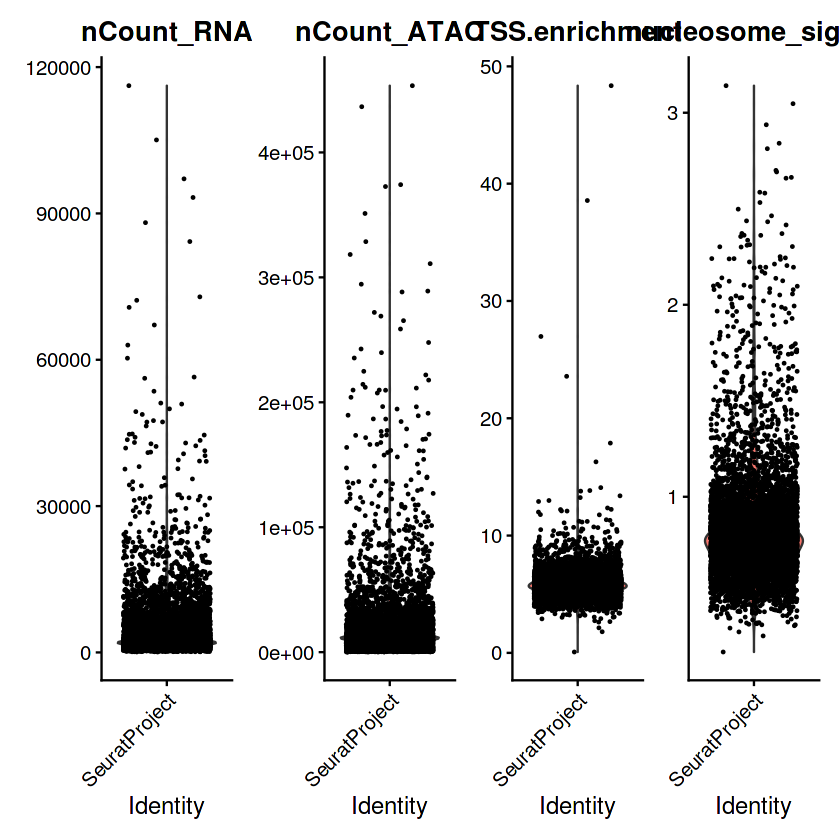

In [7]:
VlnPlot(
  object = bm_neurips,
  features = c("nCount_RNA", "nCount_ATAC", "TSS.enrichment", "nucleosome_signal"),
  ncol = 4,
  pt.size = 0.3
)

In [8]:
Idents(bm_neurips) <- "cluster"

Warning message in FetchData.Seurat(object = object, vars = features, slot = slot):
"The following requested variables were not found: atac_fragments, reads_in_peaks_frac, blacklist_fraction"


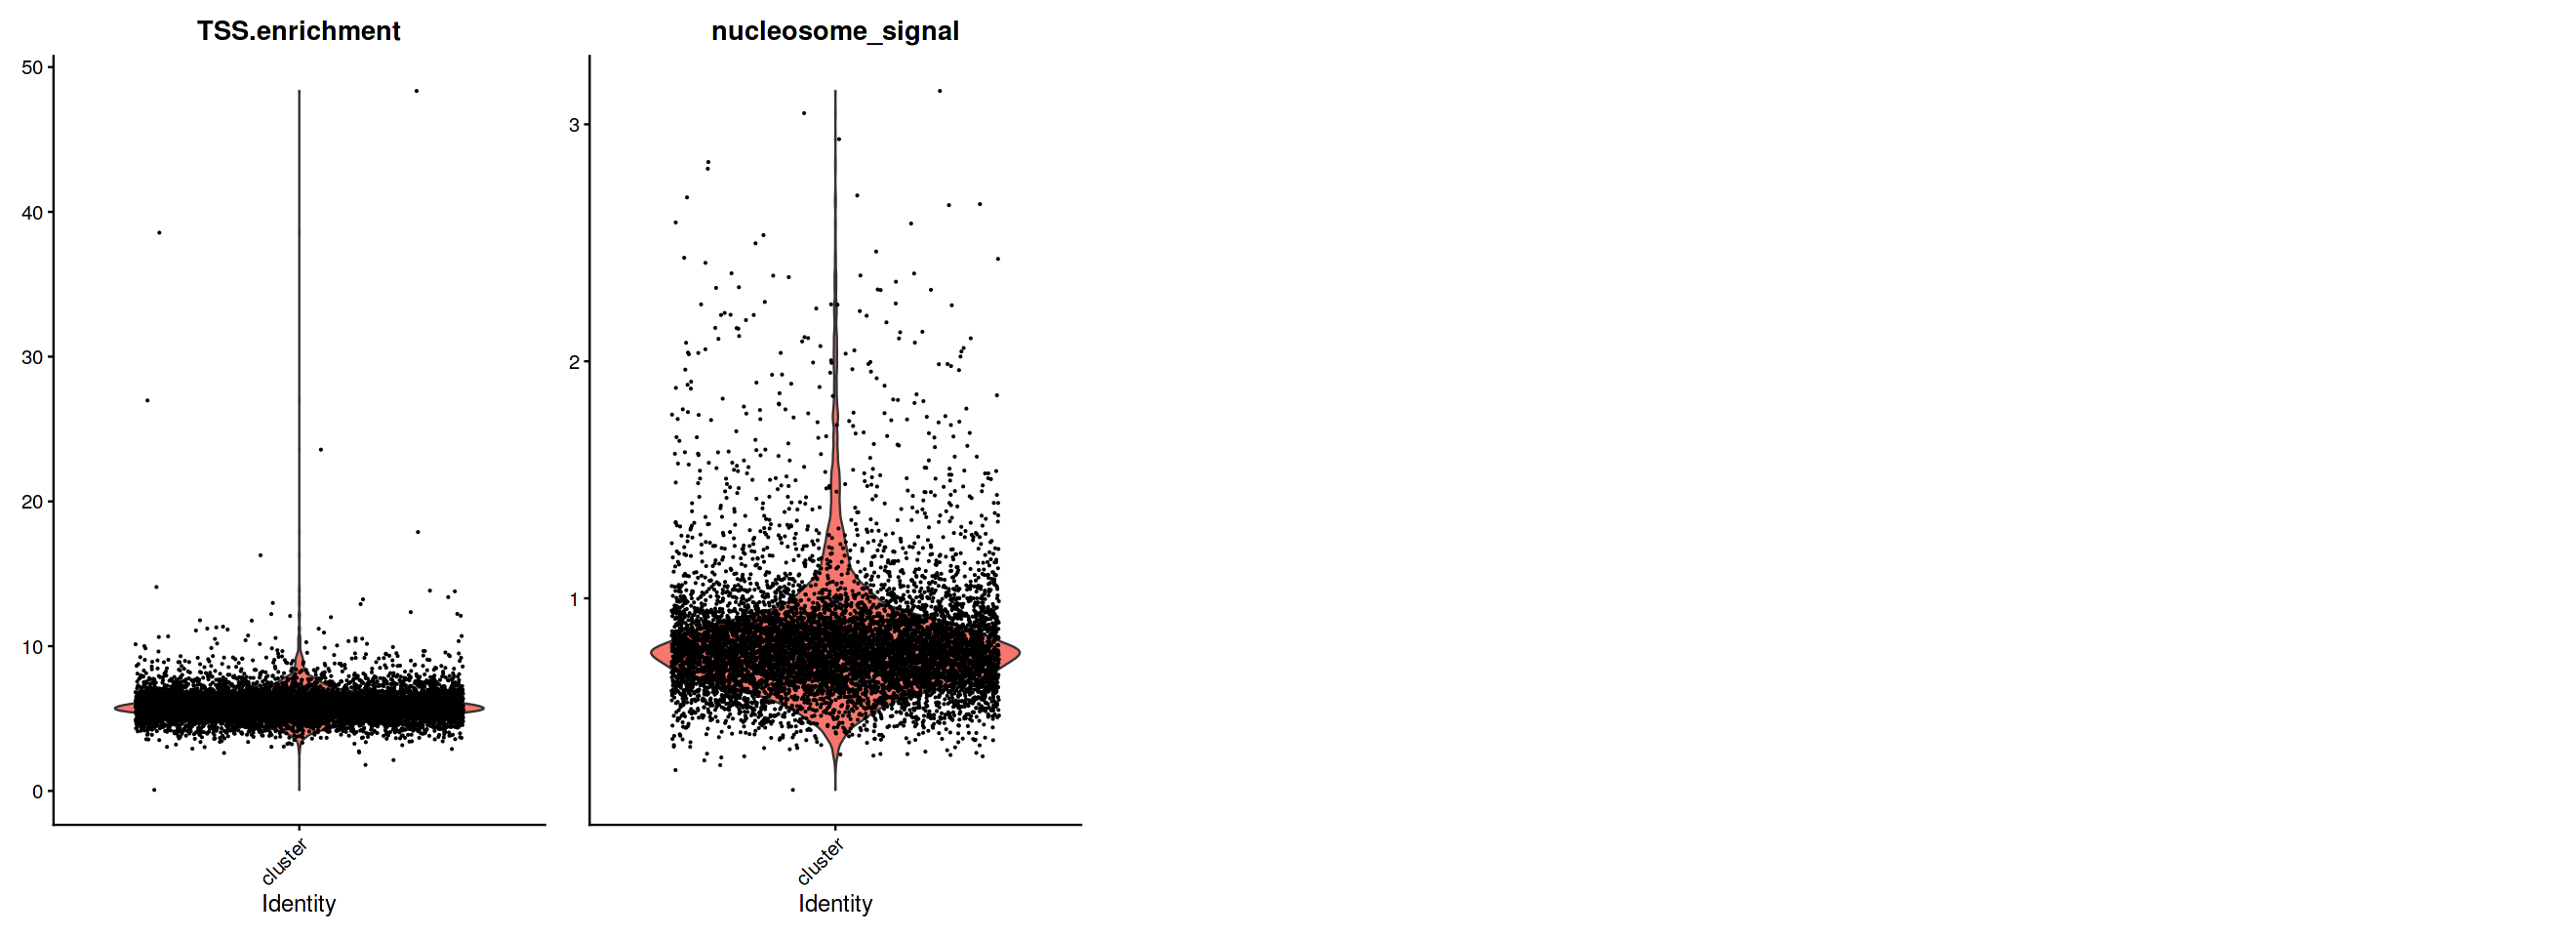

In [9]:
options(repr.plot.width=22, repr.plot.height=8) # figure size

VlnPlot(
  object = bm_neurips,
  features = c('atac_fragments','TSS.enrichment', 'reads_in_peaks_frac',
               'blacklist_fraction', 'nucleosome_signal'),
  pt.size = 0.1,
  ncol = 5
)

In [10]:
# filter out low quality cells
bm_neurips <- subset(
  x = bm_neurips,
  subset = nCount_ATAC < 100000 &
    nCount_RNA < 25000 &
    nCount_ATAC > 1000 &
    nCount_RNA > 1000 &
    nucleosome_signal < 2 &
    TSS.enrichment > 1
)
bm_neurips

An object of class Seurat 
161346 features across 7238 samples within 2 assays 
Active assay: ATAC (124745 features, 0 variable features)
 1 other assay present: RNA

In [11]:
bm_neurips <- RunTFIDF(bm_neurips)
bm_neurips <- FindTopFeatures(bm_neurips, min.cutoff = 'q0')
bm_neurips <- RunSVD(bm_neurips)

Performing TF-IDF normalization

Warning message in RunTFIDF.default(object = GetAssayData(object = object, slot = "counts"), :
"Some features contain 0 total counts"
Running SVD

Scaling cell embeddings



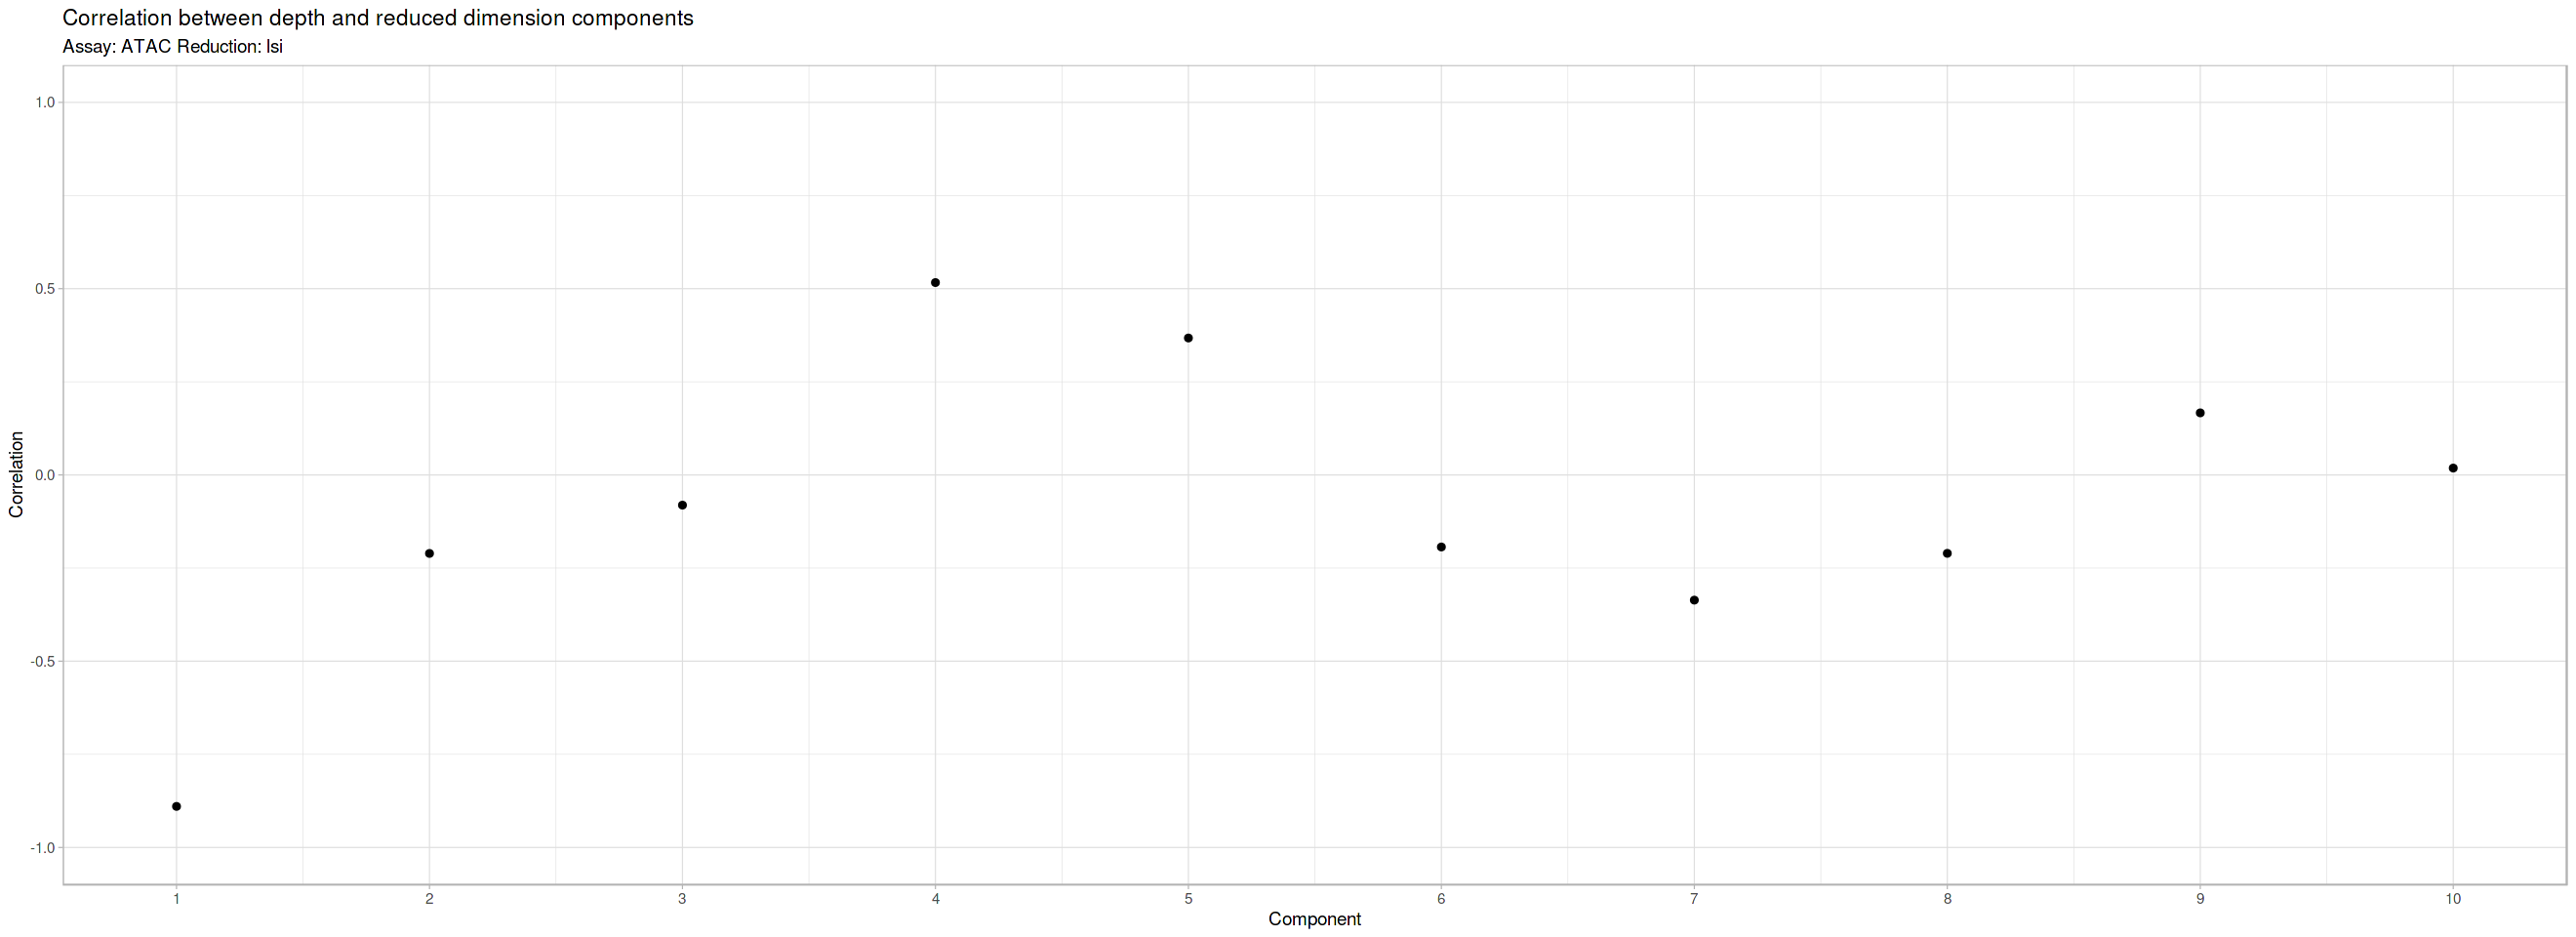

In [12]:
DepthCor(bm_neurips)

In [13]:
bm_neurips <- RunUMAP(object = bm_neurips, reduction = 'lsi', dims = 2:30, reduction.name = "umap.atac", reduction.key = "atacUMAP_")


Warning message:
"The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session"
20:47:26 UMAP embedding parameters a = 0.9922 b = 1.112

20:47:26 Read 7238 rows and found 29 numeric columns

20:47:26 Using Annoy for neighbor search, n_neighbors = 30

20:47:26 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

20:47:27 Writing NN index file to temp file /scratch/local/RtmpWMUPz8/filebf5c3aa64ff1

20:47:27 Searching Annoy index using 1 thread, search_k = 3000

20:47:31 Annoy recall = 100%

20:47:33 Commencing smooth kNN distance calibration using 1 thread
 with target n_n

Computing nearest neighbor graph

Computing SNN



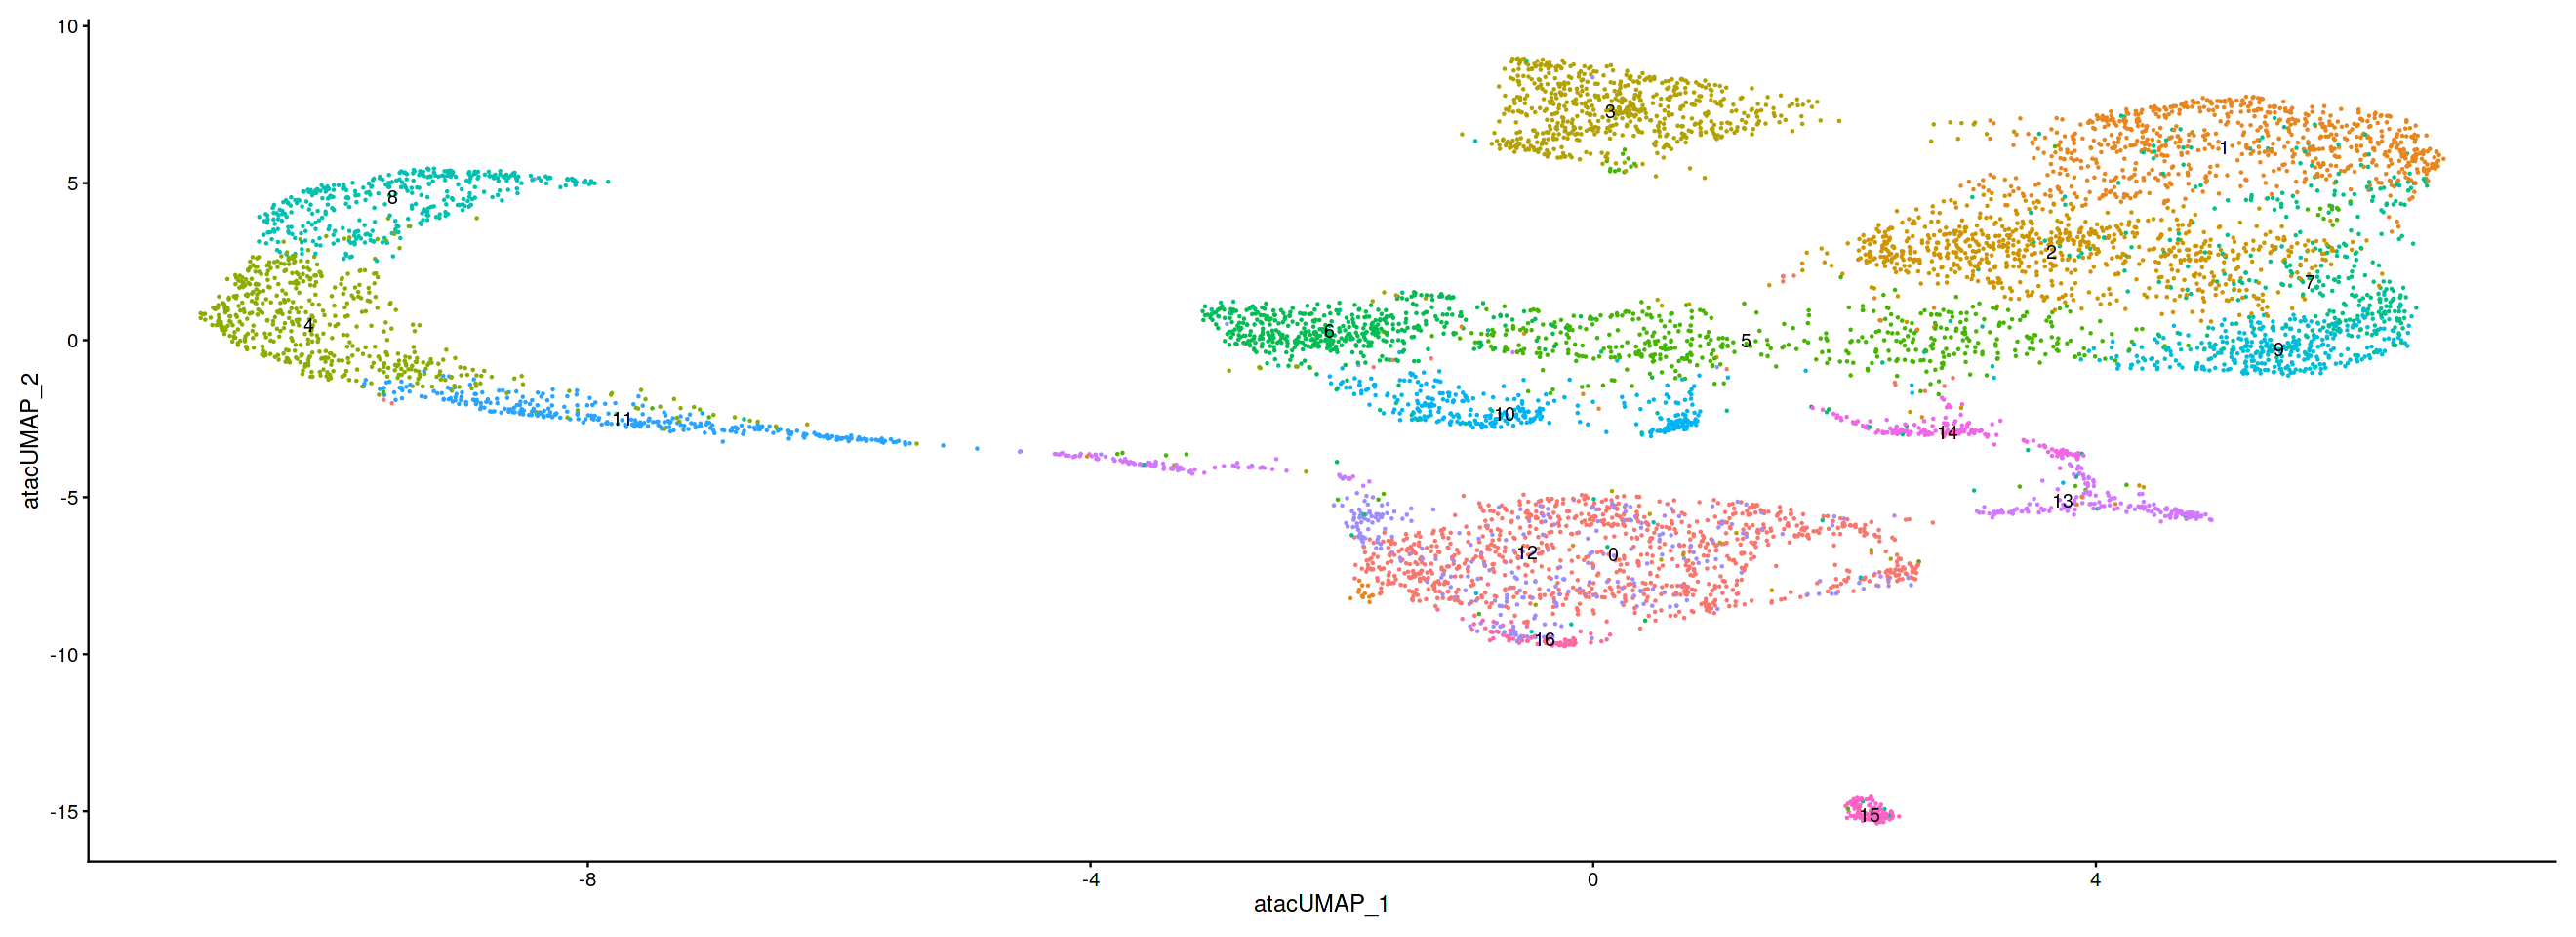

In [14]:
bm_neurips <- FindNeighbors(object = bm_neurips, reduction = 'lsi', dims = 2:30)
bm_neurips <- FindClusters(object = bm_neurips, verbose = FALSE, algorithm = 3)
DimPlot(object = bm_neurips, label = TRUE) + NoLegend()

In [15]:
## quantify gene activity
gene.activities <- GeneActivity(bm_neurips)

# add gene activities as a new assay
bm_neurips[["ACTIVITY"]] <- CreateAssayObject(counts = gene.activities)

# normalize gene activities
DefaultAssay(bm_neurips) <- "ACTIVITY"
bm_neurips <- NormalizeData(bm_neurips)
bm_neurips <- ScaleData(bm_neurips, features = rownames(bm_neurips))


Extracting gene coordinates

Extracting reads overlapping genomic regions

Centering and scaling data matrix



In [16]:
bm_neurips

An object of class Seurat 
180953 features across 7238 samples within 3 assays 
Active assay: ACTIVITY (19607 features, 0 variable features)
 2 other assays present: RNA, ATAC
 2 dimensional reductions calculated: lsi, umap.atac

## scATAC-seq annotation

### it is recommended that gene activity matrix is only exposed to logtransformation: https://github.com/stuart-lab/signac/discussions/510 +  https://github.com/stuart-lab/signac/issues/433

In [17]:
#load reference data
#InstallData("bmcite")
bm_ref <- LoadData(ds = "bmcite")
#load query data

UMAP will return its model

20:59:44 UMAP embedding parameters a = 0.9922 b = 1.112

20:59:46 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 20

20:59:49 Initializing from normalized Laplacian + noise (using irlba)

20:59:51 Commencing optimization for 200 epochs, with 983596 positive edges

21:00:12 Optimization finished

21:00:12 Note: model requested with precomputed neighbors. For transforming new data, distance data must be provided separately



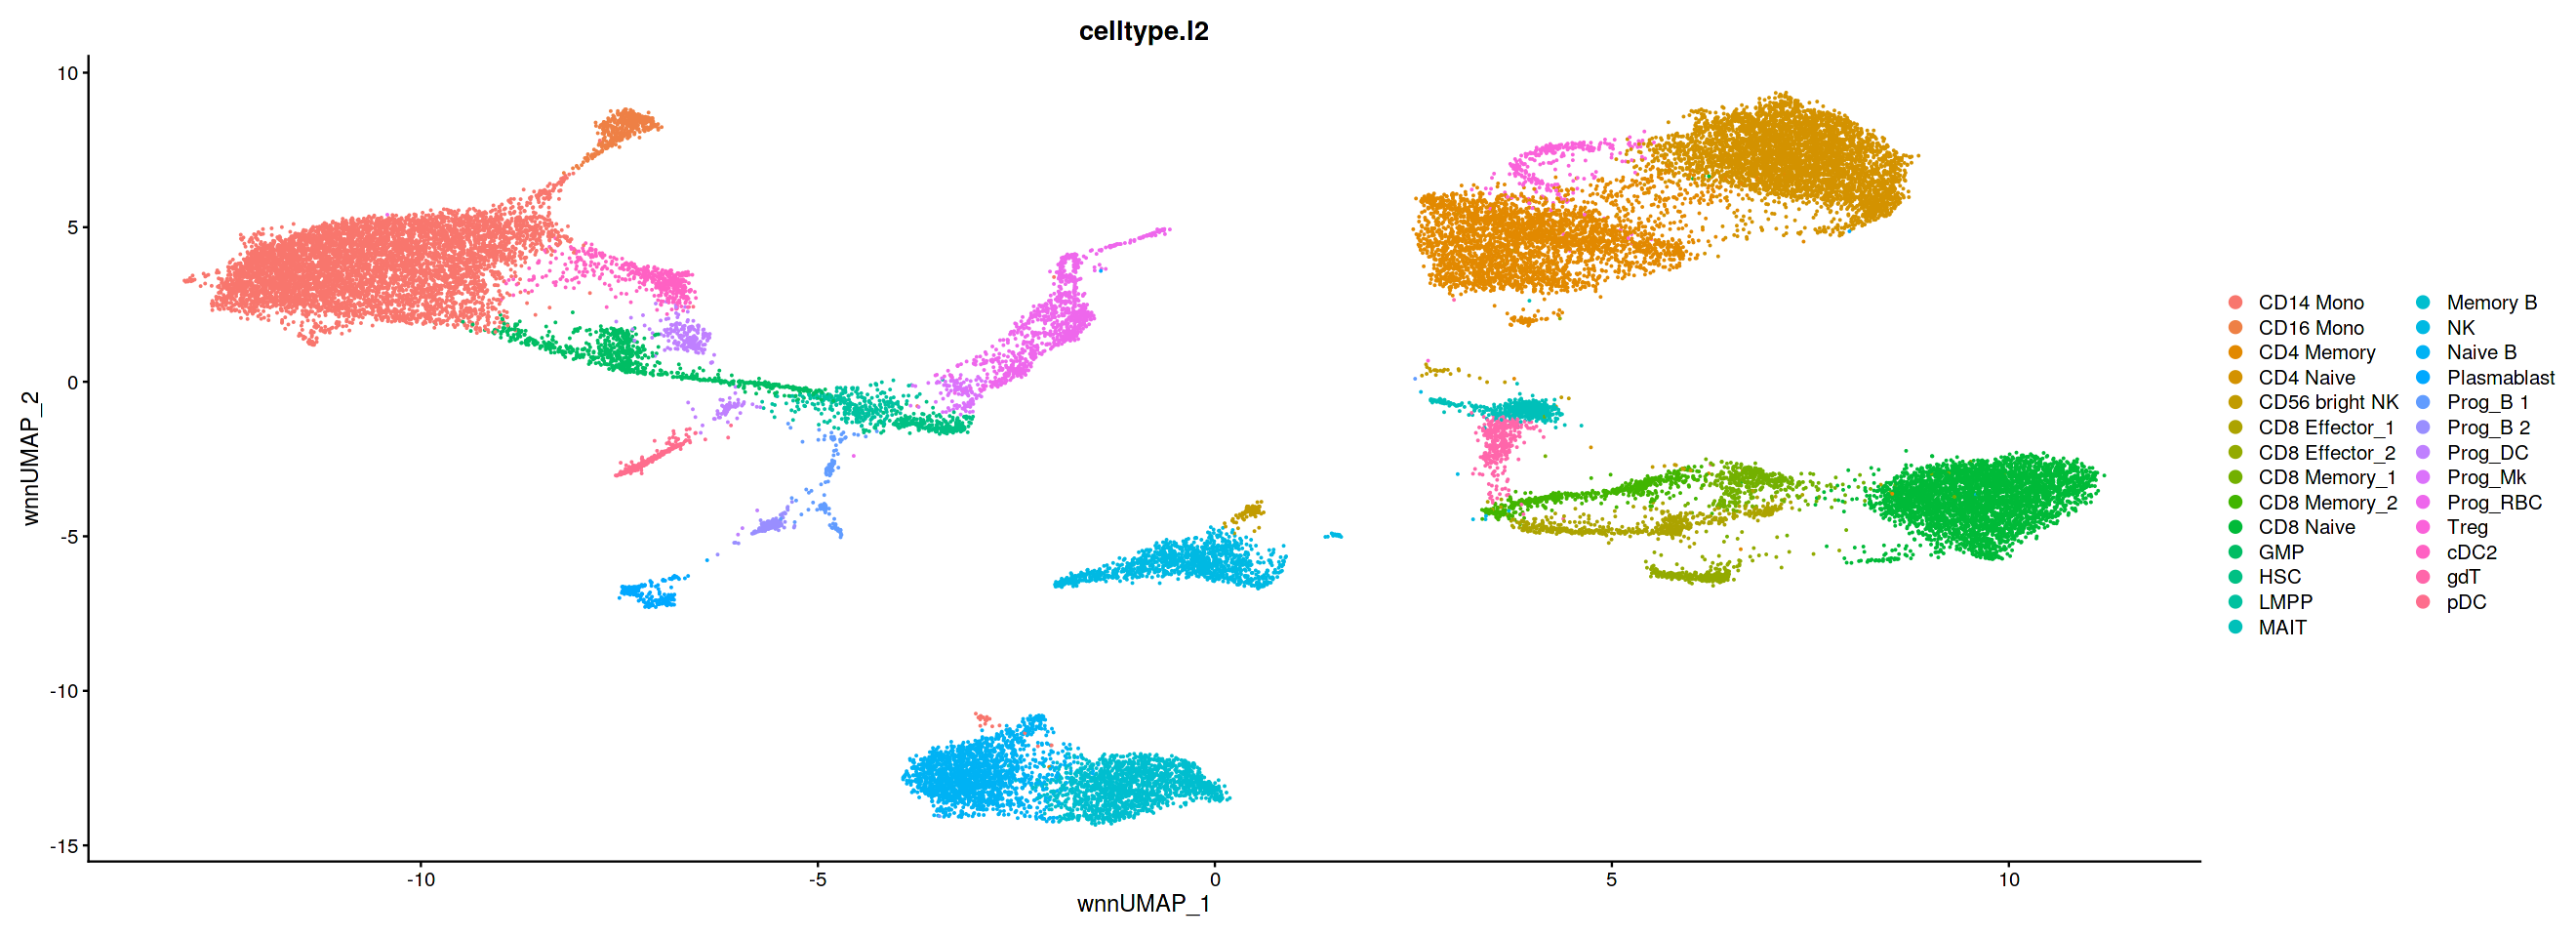

In [18]:
bm_ref <- RunUMAP(bm_ref, nn.name = "weighted.nn", reduction.name = "wnn.umap", 
              reduction.key = "wnnUMAP_", return.model = TRUE)
DimPlot(bm_ref, group.by = "celltype.l2", reduction = "wnn.umap") 

In [19]:
bm_ref <- ScaleData(bm_ref, assay = 'RNA')
bm_ref <- RunSPCA(bm_ref, assay = 'RNA', graph = 'wsnn')

Centering and scaling data matrix

Computing sPCA transformation



### as per the guidelines, both the refernece and the query should have the same normalization method applied for label trasfer. As gene.activity matrix can only have log transformation, we should apply the same for the reference as well.

In [20]:
bm_ref

An object of class Seurat 
17034 features across 30672 samples within 2 assays 
Active assay: RNA (17009 features, 2000 variable features)
 1 other assay present: ADT
 2 dimensional reductions calculated: spca, wnn.umap

In [21]:
bm_ref_logTransformedRNA <- CreateAssayObject(counts = bm_ref@assays$RNA@counts)

In [22]:
bm_ref[["logTransformedRNA"]] <- bm_ref_logTransformedRNA

In [23]:
DefaultAssay(bm_ref) <- "logTransformedRNA"

In [24]:
bm_ref

An object of class Seurat 
34043 features across 30672 samples within 3 assays 
Active assay: logTransformedRNA (17009 features, 0 variable features)
 2 other assays present: RNA, ADT
 2 dimensional reductions calculated: spca, wnn.umap

In [25]:
bm_ref <- NormalizeData(
  bm_ref,
  normalization.method = "LogNormalize")

In [26]:
bm_ref@assays$logTransformedRNA

Assay data with 17009 features for 30672 cells
First 10 features:
 FO538757.2, AP006222.2, RP4-669L17.10, RP11-206L10.9, LINC00115,
FAM41C, SAMD11, NOC2L, KLHL17, PLEKHN1 

In [27]:
bm_ref <- FindVariableFeatures(bm_ref)
bm_ref <- ScaleData(bm_ref)
bm_ref <- RunPCA(bm_ref)
bm_ref <- RunUMAP(bm_ref, dims = 1:30)


Centering and scaling data matrix

PC_ 1 
Positive:  TRBC1, LAT, CD8B, CCL5, KLRB1, IGKC, S100A12, GZMA, S100A8, S100A9 
	   MS4A1, S100B, GNLY, CST7, TYROBP, KLRD1, RP11-291B21.2, NKG7, VCAN, CD14 
	   IGLC2, CCL4, AC092580.4, FCN1, IGLC3, PRF1, RBP7, SERPINA1, DUSP2, JUN 
Negative:  KIAA0101, TYMS, KLF1, KCNH2, FAM178B, APOC1, CNRIP1, CENPU, GATA1, BIRC5 
	   CENPF, EPCAM, CKS2, RP11-620J15.3, TUBA1B, TFR2, CA1, HMGA1, STMN1, HIST1H4C 
	   CDT1, AHSP, TOP2A, TK1, GFI1B, TUBB, MKI67, NME4, SMIM1, TMEM56 
PC_ 2 
Positive:  RPL3, RPS3, RPS18, RPS5, RPS4X, RPSA, RPS12, RPS23, RPS2, EEF1B2 
	   RPL4, LDHB, NPM1, RPS17, RPLP0, TRBC1, LAT, RPL7A, GYPC, HSPA8 
	   CD8B, KLRB1, CCL5, HNRNPA1, PEBP1, RPL37A, MYC, NUCB2, SOD1, CD79A 
Negative:  LYZ, FCN1, CST3, TYROBP, S100A9, LST1, S100A8, CSTA, MNDA, VCAN 
	   LGALS1, AIF1, S100A12, CFD, SERPINA1, FCER1G, MS4A6A, FOS, S100A6, CD14 
	   LGALS2, FTH1, GAPDH, ANXA2, CD36, CPVL, RBP7, HLA-DRA, LINC01272, H3F3A 
PC_ 3 
Positive:  CD74, HLA-DRA, HL

In [28]:
bm_ref <- RunSPCA(bm_ref, reduction.key = "SPC_logTr_", assay = 'logTransformedRNA', graph = 'wsnn')


Computing sPCA transformation

Warning message:
"Keys should be one or more alphanumeric characters followed by an underscore, setting key from SPC_logTr_ to SPClogTr_"
Warning message:
"All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to SPClogTr_"


In [29]:
bm_ref

An object of class Seurat 
34043 features across 30672 samples within 3 assays 
Active assay: logTransformedRNA (17009 features, 2000 variable features)
 2 other assays present: RNA, ADT
 4 dimensional reductions calculated: spca, wnn.umap, pca, umap

In [30]:
bm_ref <- FindNeighbors(
  object = bm_ref,
  reduction = "spca",
  dims = 1:50,
  graph.name = "spca.annoy.neighbors", 
  k.param = 50,
  cache.index = TRUE,
  return.neighbor = TRUE,
  l2.norm = TRUE
)

Computing nearest neighbors

Only one graph name supplied, storing nearest-neighbor graph only



In [31]:
bm_ref

An object of class Seurat 
34043 features across 30672 samples within 3 assays 
Active assay: logTransformedRNA (17009 features, 2000 variable features)
 2 other assays present: RNA, ADT
 4 dimensional reductions calculated: spca, wnn.umap, pca, umap

In [32]:
bm_ref <- RunUMAP(bm_ref, nn.name = "weighted.nn", reduction.name = "wnn.umap", reduction.key = "wnnUMAP_")


21:10:28 UMAP embedding parameters a = 0.9922 b = 1.112

21:10:32 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 20

21:10:40 Initializing from normalized Laplacian + noise (using irlba)

21:10:43 Commencing optimization for 200 epochs, with 983596 positive edges

21:11:03 Optimization finished



In [33]:
bm_ref <- FindClusters(bm_ref, graph.name = "wsnn", algorithm = 3, resolution = 2, verbose = FALSE)

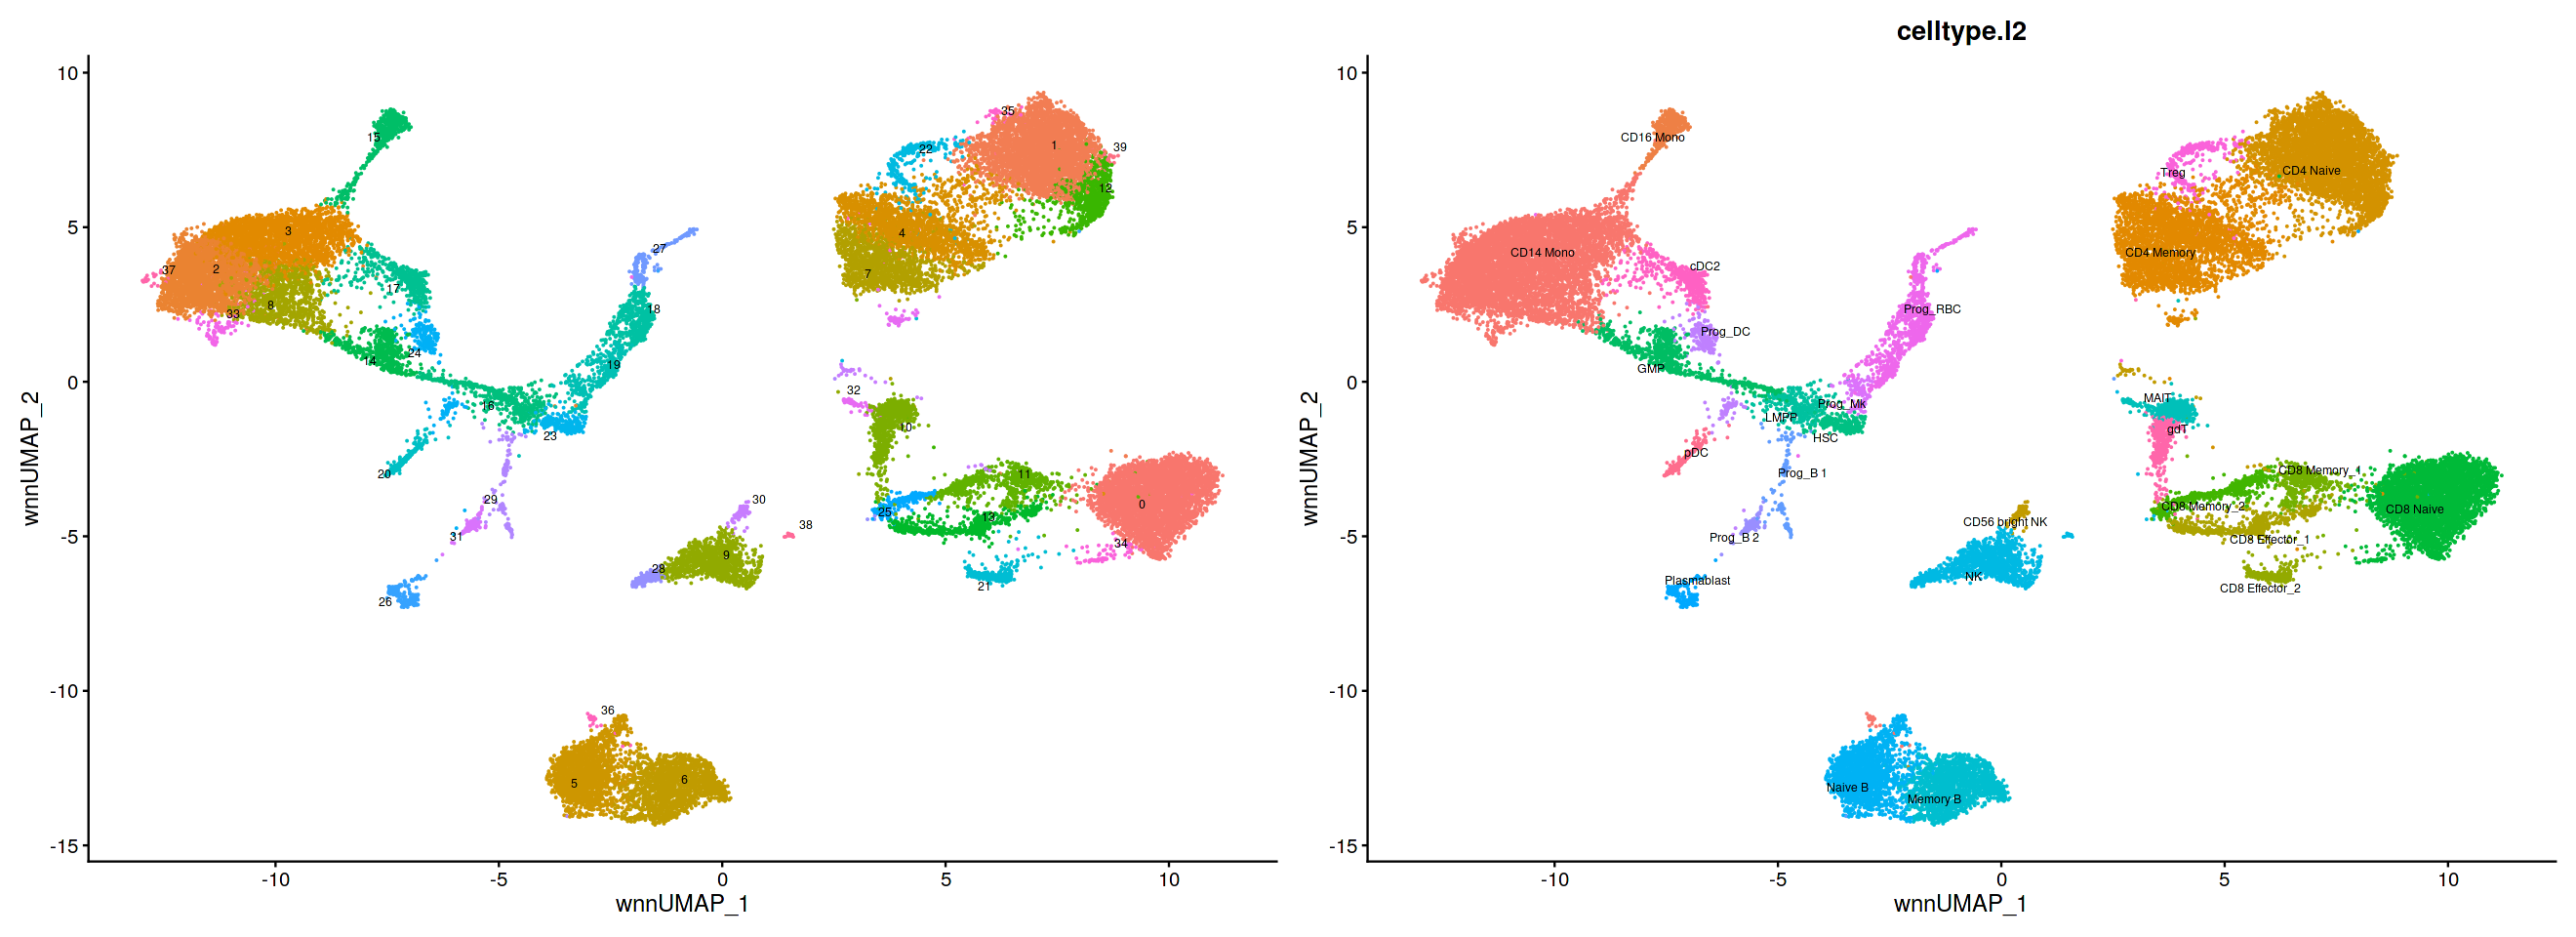

In [34]:
p1 <- DimPlot(bm_ref, reduction = 'wnn.umap', label = TRUE, repel = TRUE, label.size = 2.5) + NoLegend()
p2 <- DimPlot(bm_ref, reduction = 'wnn.umap', group.by = 'celltype.l2', label = TRUE, repel = TRUE, label.size = 2.5) + NoLegend()
p1 + p2

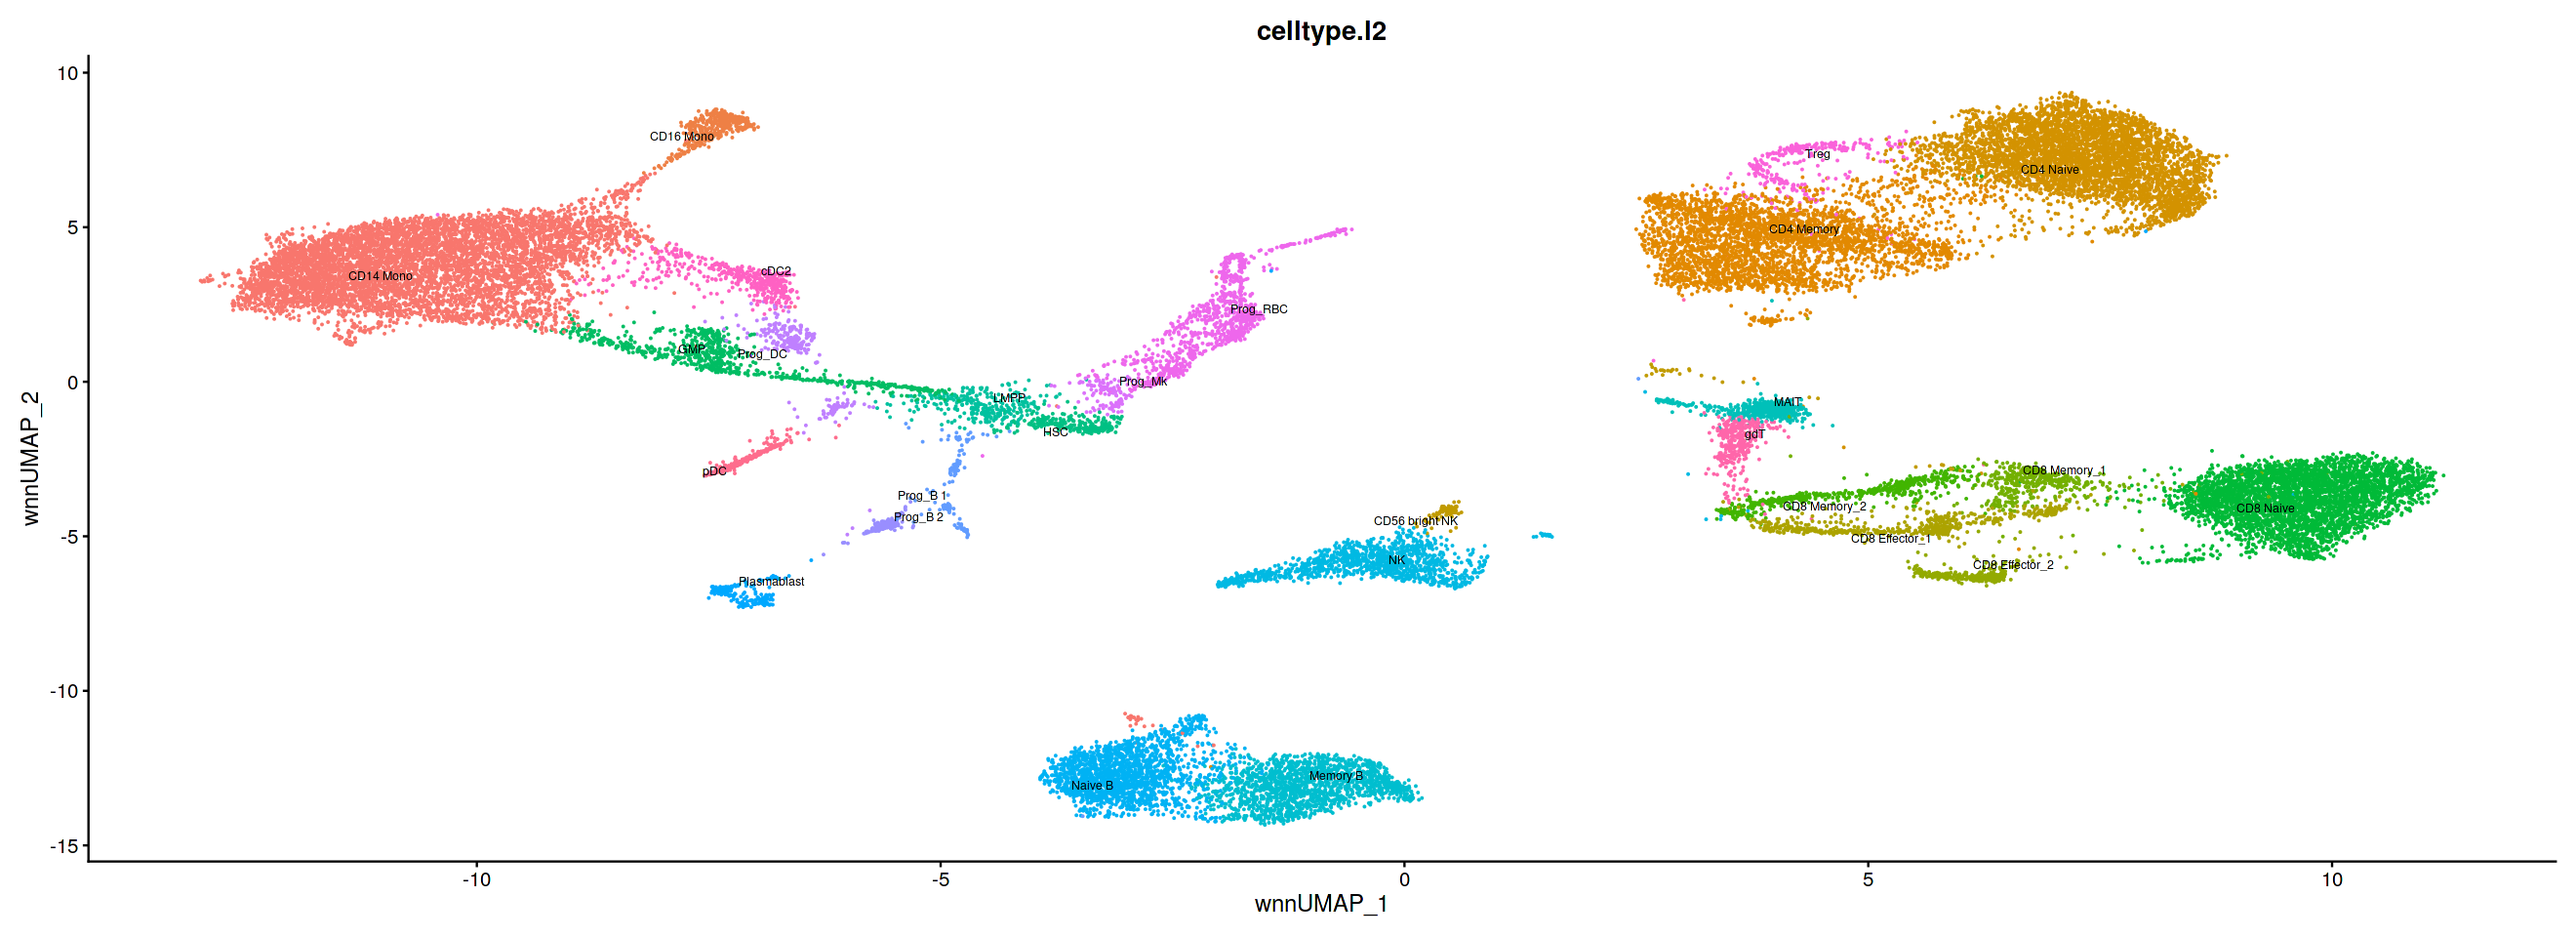

In [35]:
DimPlot(bm_ref, reduction = 'wnn.umap', group.by = 'celltype.l2', label = TRUE, repel = TRUE, label.size = 2.5) + NoLegend()


### get the variable features from gene activity object

In [36]:
bm_neurips <- FindVariableFeatures(bm_neurips, selection.method = "vst", nfeatures = 3000)

In [37]:
bm_neurips

An object of class Seurat 
180953 features across 7238 samples within 3 assays 
Active assay: ACTIVITY (19607 features, 3000 variable features)
 2 other assays present: RNA, ATAC
 2 dimensional reductions calculated: lsi, umap.atac

## label transfer

In [38]:
anchors <- FindTransferAnchors(
    reference = bm_ref,
    query = bm_neurips,
    k.filter = NA,
    reference.reduction = "spca", 
    reference.neighbors = "spca.annoy.neighbors", 
    dims = 1:50,
    reference.assay = 'logTransformedRNA'
  )


Projecting cell embeddings

Finding neighborhoods

Finding anchors

	Found 367 anchors



### through the standard pipeline we retained only a small number of anchors, so we will try with cca now..

In [39]:
unique(bm_ref@meta.data$celltype.l2)

[1] "Prog_RBC"       "gdT"            "CD4 Naive"      "CD4 Memory"    
 [5] "CD14 Mono"      "Naive B"        "CD8 Naive"      "Treg"          
 [9] "CD8 Effector_2" "NK"             "GMP"            "CD8 Effector_1"
[13] "CD16 Mono"      "pDC"            "CD8 Memory_1"   "MAIT"          
[17] "Memory B"       "cDC2"           "CD56 bright NK" "Prog_B 2"      
[21] "Prog_Mk"        "CD8 Memory_2"   "Plasmablast"    "HSC"           
[25] "LMPP"           "Prog_DC"        "Prog_B 1"

In [40]:
bm.cca.anchors <- FindTransferAnchors(reference = bm_ref, query = bm_neurips, reduction = 'cca', dims = 1:30, 
                               reference.assay = 'logTransformedRNA', query.assay = 'RNA', normalization.method = 'LogNormalize')


Warning message in RunCCA.Seurat(object1 = reference, object2 = query, features = features, :
"Running CCA on different assays"
Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 20250 anchors

Filtering anchors

	Retained 3630 anchors



In [41]:
bm.cca.anchors

An AnchorSet object containing 3630 anchors between the reference and query Seurat objects. 
 This can be used as input to TransferData.

In [42]:
bm_neurips <- TransferData(
  anchorset = bm.cca.anchors, 
  reference = bm_ref,
  query = bm_neurips,
  refdata = list(
    celltype.l1 = "celltype.l1",
    celltype.l2 = "celltype.l2",
    predicted_ADT = "ADT"),
    weight.reduction = 'cca'
)

Finding integration vectors

Finding integration vector weights

Predicting cell labels

Warning message:
"Keys should be one or more alphanumeric characters followed by an underscore, setting key from predictionscorecelltype.l1_ to predictionscorecelltypel1_"
Predicting cell labels

Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"
Warning message:
"Keys should be one or more alphanumeric characters followed by an underscore, setting key from predictionscorecelltype.l2_ to predictionscorecelltypel2_"
Transfering 25 features onto reference data

Warning message:
"Keys should be one or more alphanumeric characters followed by an underscore, setting key from predicted_ADT_ to predictedADT_"


In [43]:
bm_neurips <- IntegrateEmbeddings(
  anchorset = bm.cca.anchors,
  reference = bm_ref,
  query = bm_neurips, 
  new.reduction.name = "ref.cca",
  reductions = "cca",
)


Integrating dataset 2 with reference dataset

Finding integration vectors

Integrating data



In [46]:
save.image(file=paste(results_dir ,'WS.RData', sep=''))

### export gene activity matrix

In [48]:

write.csv(as.data.frame(as.matrix(bm_neurips@assays$ACTIVITY@counts)), paste(results_dir ,"bm_neurips_atac_gene_activity_matrix.csv", sep=''))

Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 1.1 GiB"


Warning message:
"ggrepel: 17 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


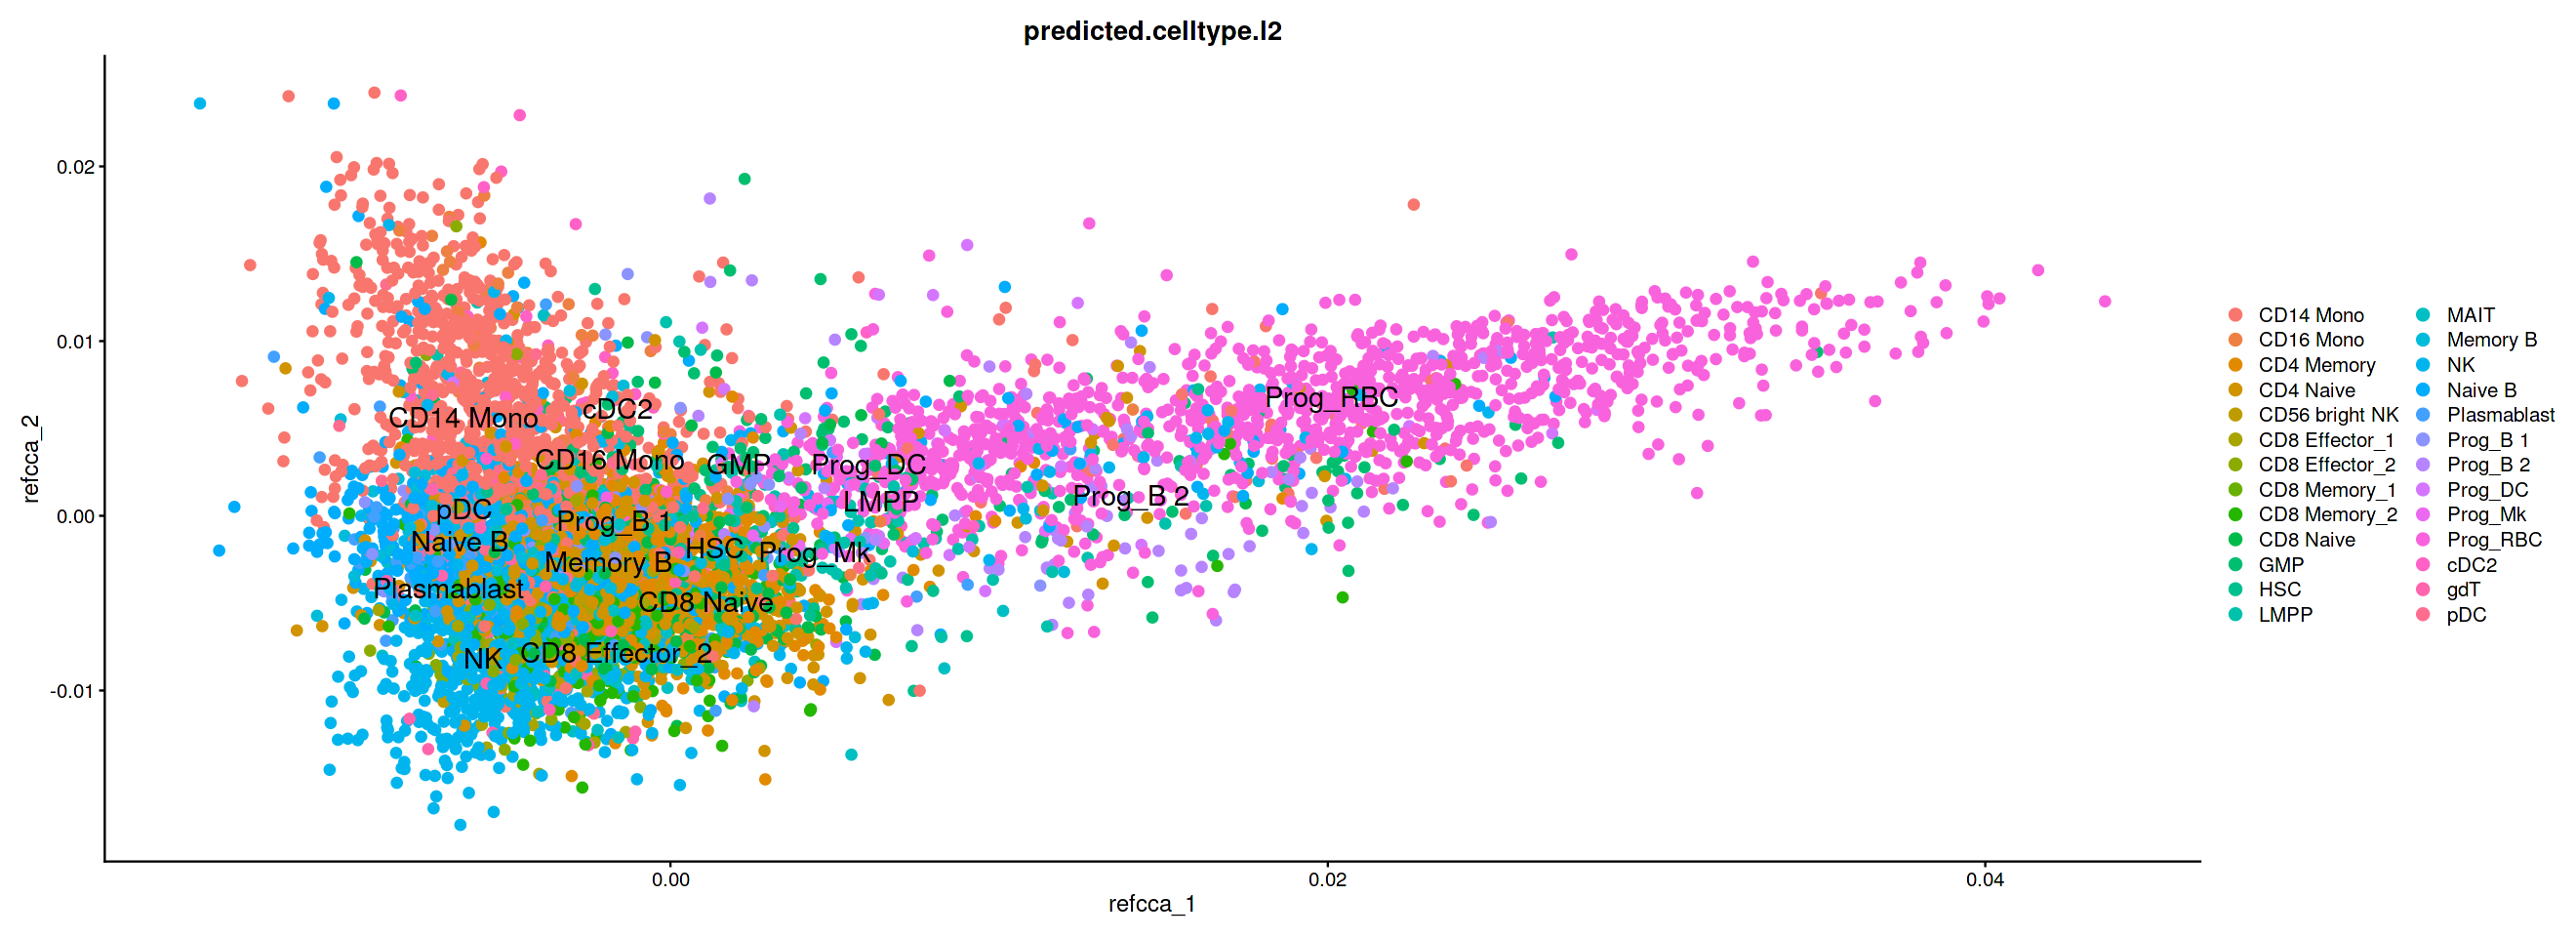

In [49]:
DimPlot(bm_neurips, reduction = "ref.cca", group.by = "predicted.celltype.l2", label = TRUE, label.size = 6 ,repel = TRUE, pt.size = 2.5)


In [50]:
bm_neurips

An object of class Seurat 
181010 features across 7238 samples within 6 assays 
Active assay: ACTIVITY (19607 features, 3000 variable features)
 5 other assays present: RNA, ATAC, prediction.score.celltype.l1, prediction.score.celltype.l2, predicted_ADT
 3 dimensional reductions calculated: lsi, umap.atac, ref.cca

Warning message:
"ggrepel: 5 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


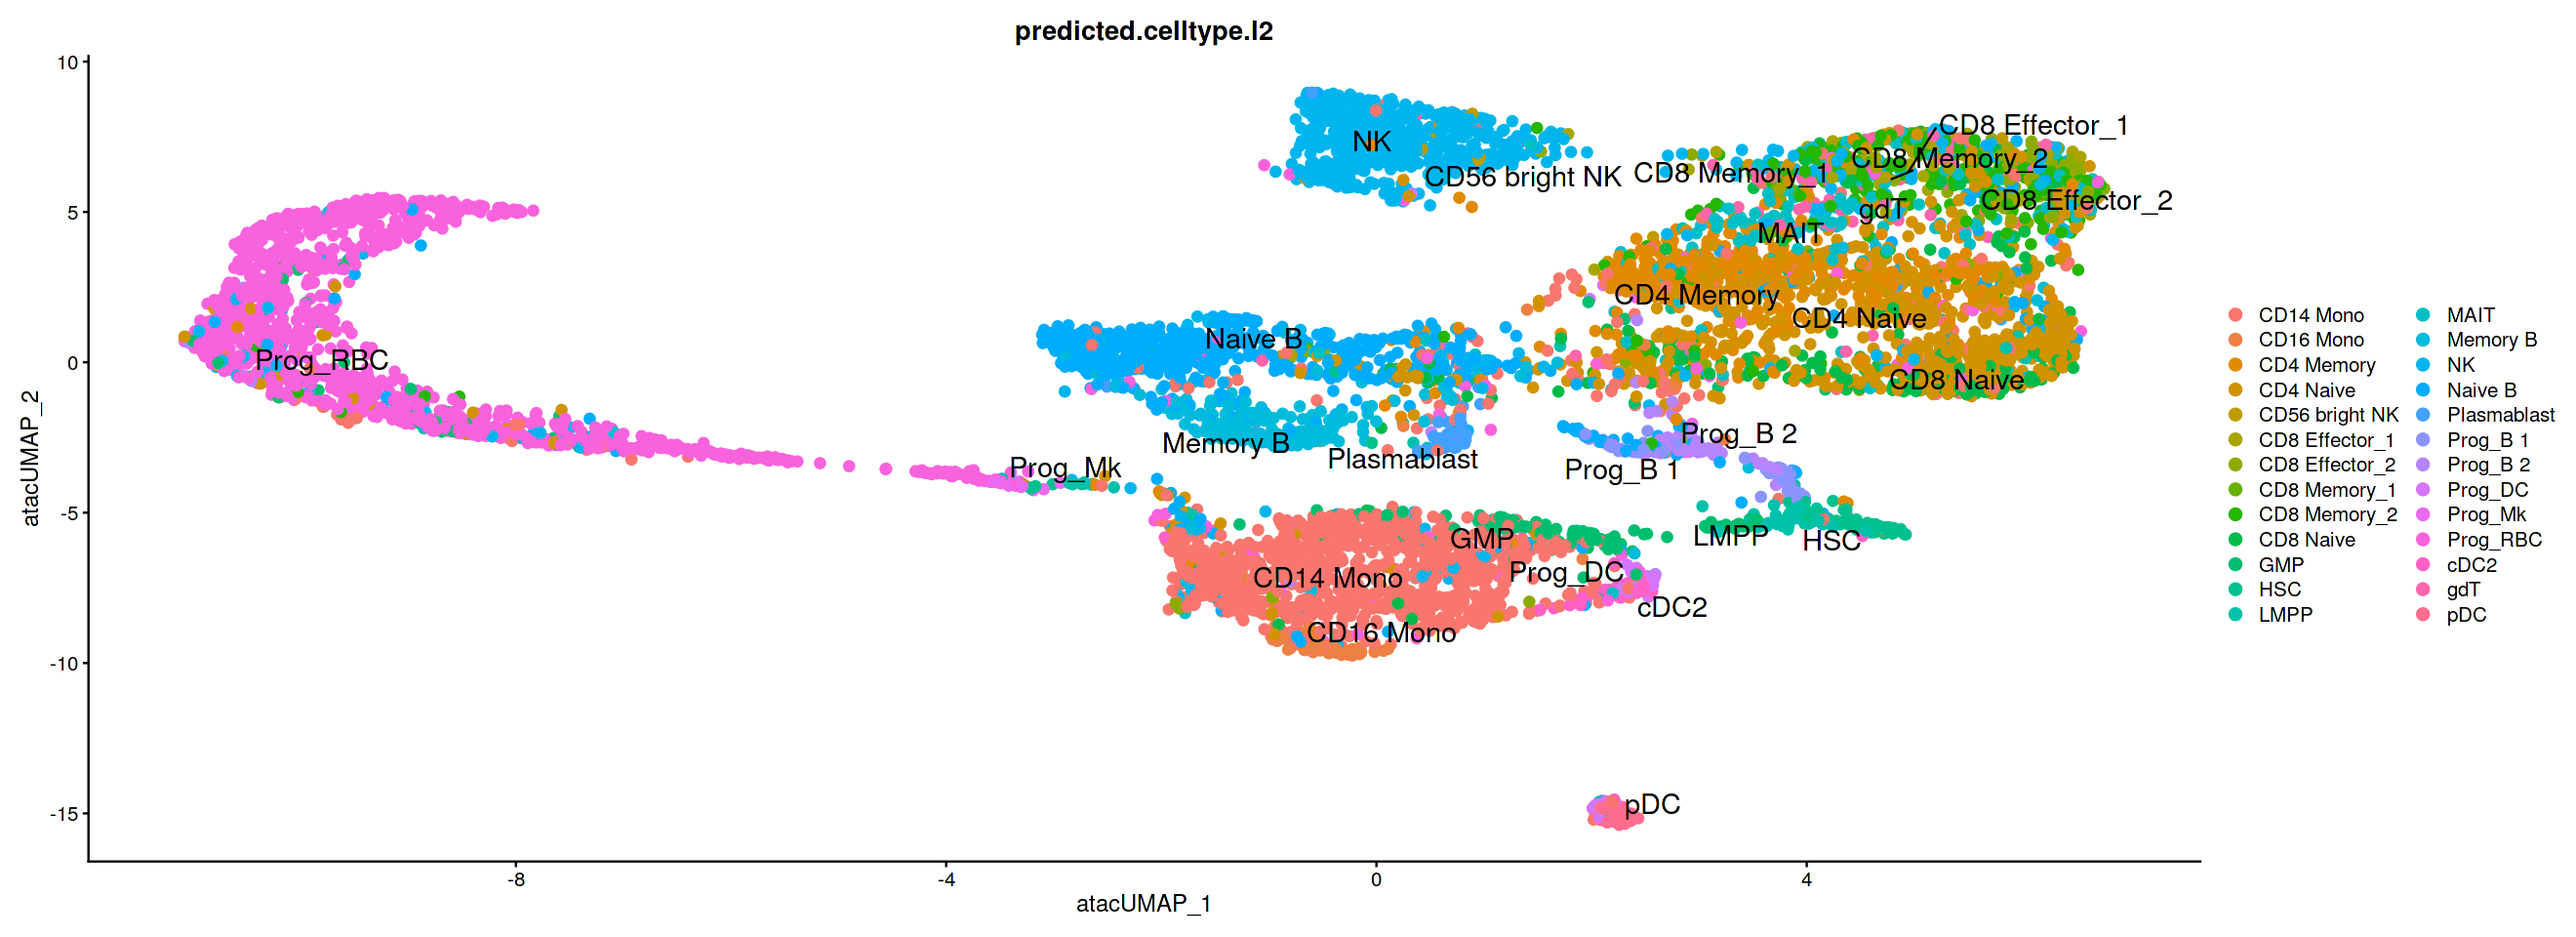

In [51]:
predicted_umap_plot  <- DimPlot(bm_neurips, reduction = "umap.atac", group.by = "predicted.celltype.l2", label = TRUE, label.size = 6 ,repel = TRUE, pt.size = 2.5)
predicted_umap_plot

In [52]:
predicted_umap_plot_aug <- AugmentPlot(plot = predicted_umap_plot, dpi=500)

In [57]:
ggsave(filename = paste(figures_dir ,"predicted_umap_aug.png", sep=''),predicted_umap_plot_aug)

Saving 6.67 x 6.67 in image



In [58]:
ggsave(filename = paste(figures_dir ,"predicted_umap.png", sep=''),predicted_umap_plot)

Saving 6.67 x 6.67 in image

Warning message:
"ggrepel: 5 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


In [59]:
real_id_plot <- DimPlot(bm_neurips, reduction = "umap.atac", group.by = "orig.ident", label = TRUE, label.size = 6 ,repel = TRUE, pt.size = 2.5)
real_id_plot_aug <-AugmentPlot(real_id_plot, width = 10, height = 10, dpi = 500)
ggsave(filename = paste(figures_dir ,"real_id_plot_aug.png", sep=''),real_id_plot_aug)


Saving 6.67 x 6.67 in image



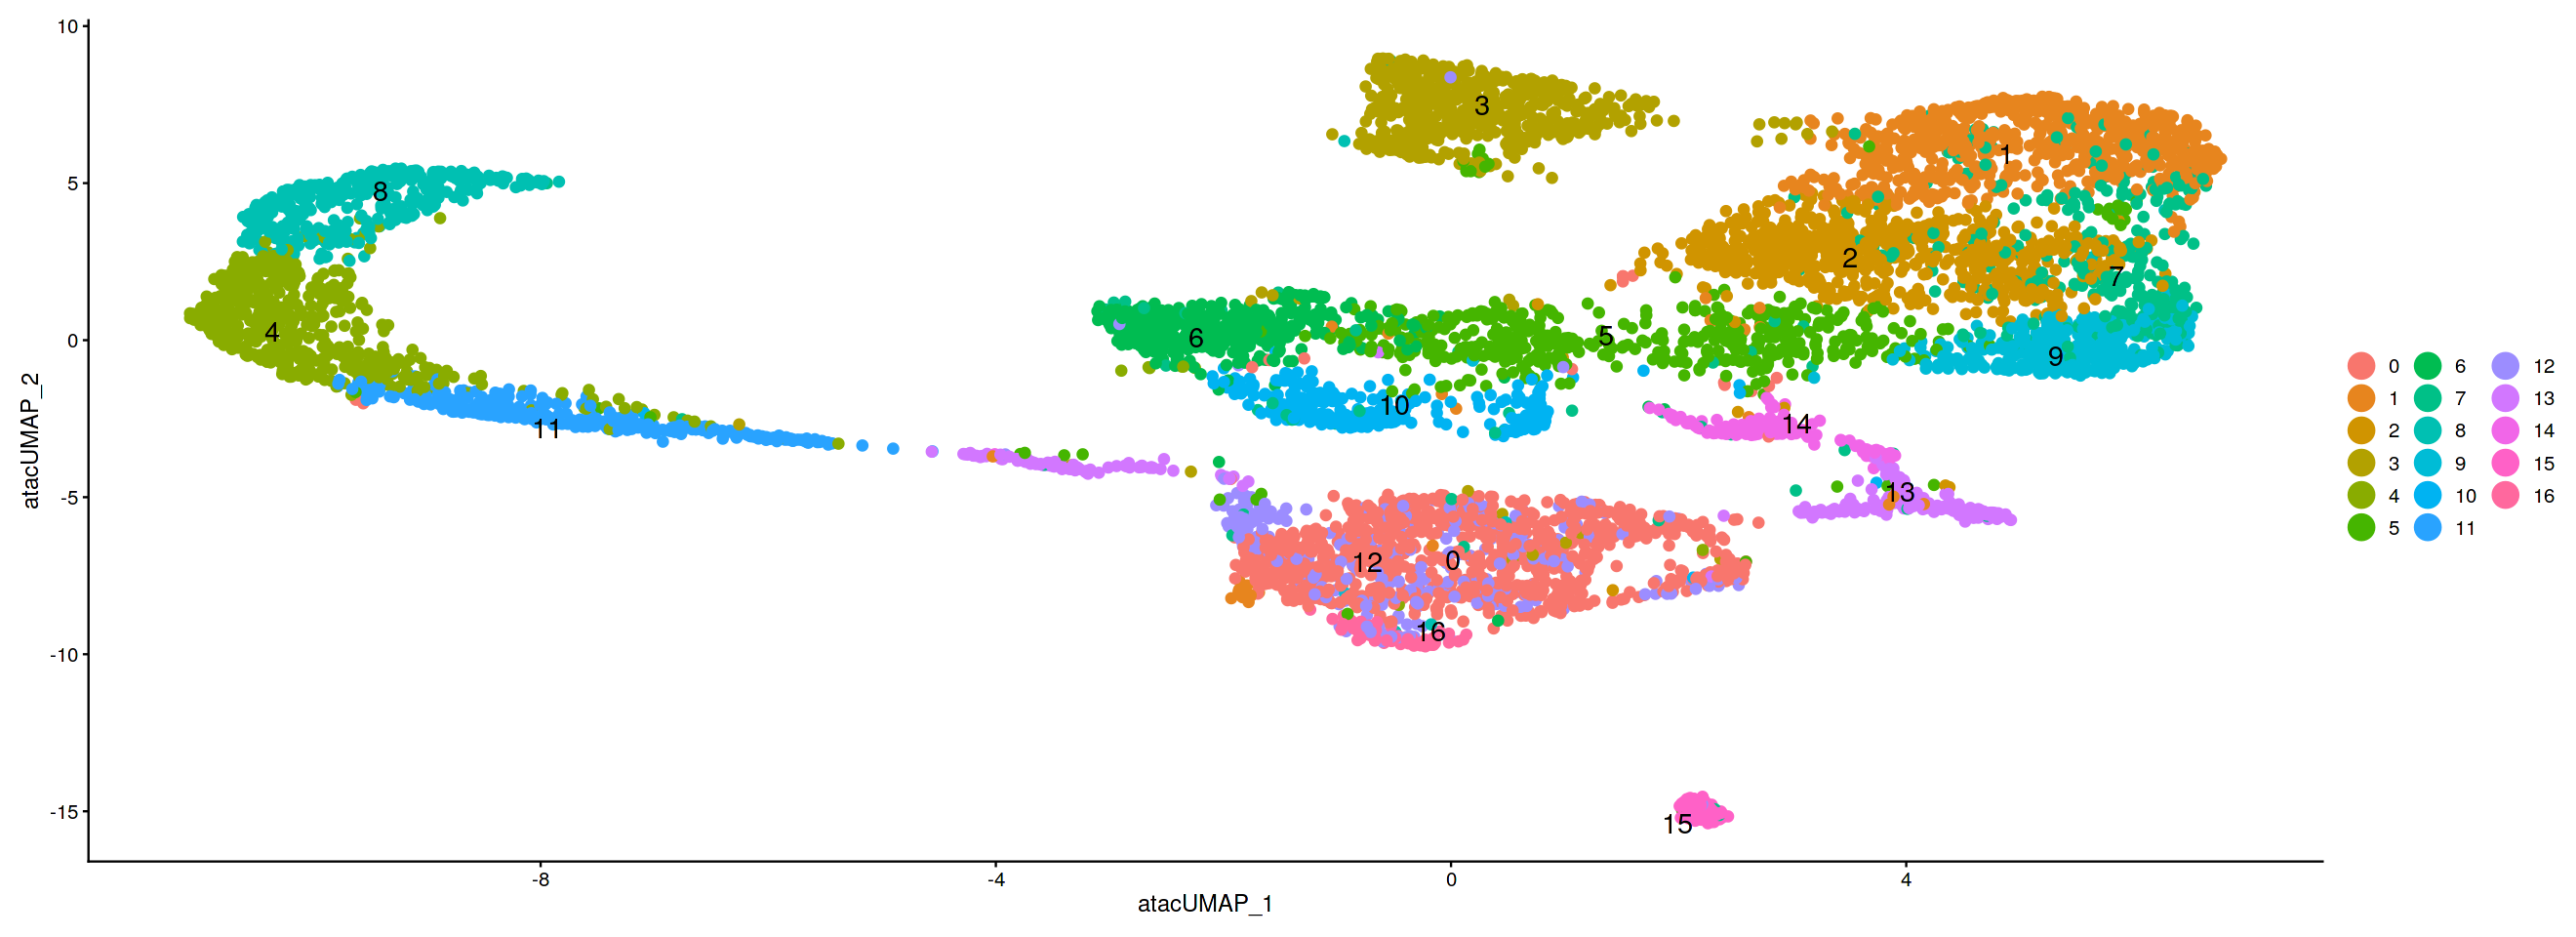

In [60]:
DimPlot(bm_neurips, reduction = "umap.atac", label = TRUE, label.size = 6 ,repel = TRUE, pt.size = 2.5) +  guides(color = guide_legend(override.aes = list(size=7), ncol=3) )


In [61]:
# save lenged separately
real_id_plot_w_legend <- DimPlot(bm_neurips, reduction = "umap.atac", group.by = "orig.ident", label = TRUE, label.size = 6 ,repel = TRUE, pt.size = 2.5) +  guides(color = guide_legend(override.aes = list(size=7), ncol=3) )

# Extract the legend. Returns a gtable
leg <- get_legend(real_id_plot_w_legend)

# Convert to a ggplot and print
save_plot(leg,filename =  paste(figures_dir ,"real_id_plot_legend.png", sep=''), dpi = 600)

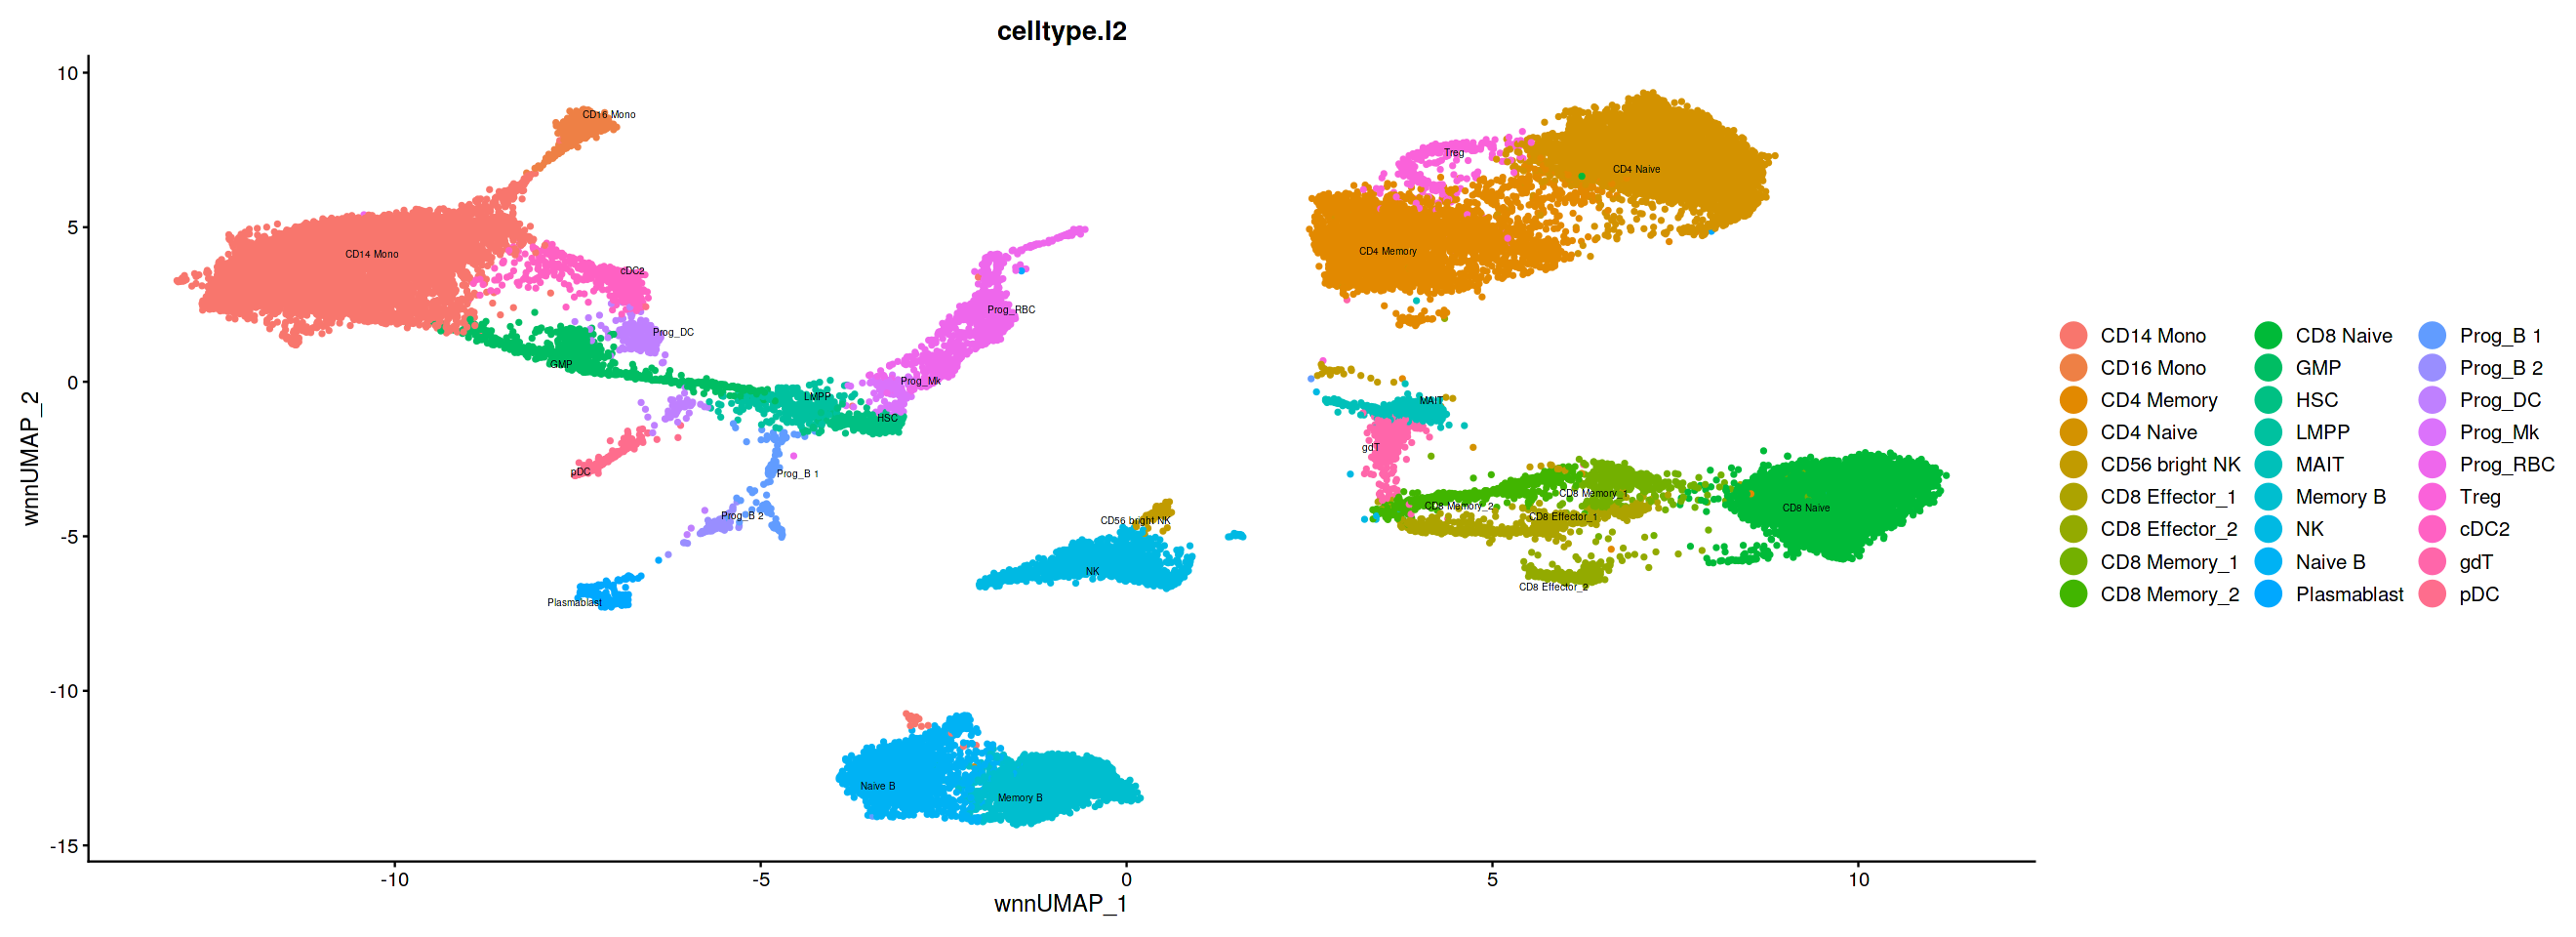

In [74]:
reference_bm_plot <- DimPlot(bm_ref, reduction = 'wnn.umap', group.by = 'celltype.l2', label = TRUE, label.size = 2,repel = TRUE, pt.size = 1)+  guides(color = guide_legend(override.aes = list(size=7), ncol=3) )
reference_bm_plot

In [77]:
# Extract the legend. Returns a gtable
leg <- get_legend(reference_bm_plot)

# Convert to a ggplot and print
save_plot(leg, filename= paste(figures_dir ,"reference_bm_plot_aug_legend.png", sep=''), dpi = 600)


In [78]:
reference_bm_plot <- DimPlot(bm_ref, reduction = 'wnn.umap', group.by = 'celltype.l2', label = TRUE, label.size = 6,repel = TRUE, pt.size = 2.5) + NoLegend()
reference_bm_plot_aug <-AugmentPlot(reference_bm_plot, width = 10, height = 10, dpi = 500)

ggsave(filename = paste(figures_dir ,"reference_bm_plot_aug.png", sep='') ,reference_bm_plot_aug)

Saving 6.67 x 6.67 in image



In [65]:
colnames(bm_neurips@meta.data)

[1] "orig.ident"                  "nCount_RNA"                 
 [3] "nFeature_RNA"                "nCount_ATAC"                
 [5] "nFeature_ATAC"               "nucleosome_signal"          
 [7] "nucleosome_percentile"       "TSS.enrichment"             
 [9] "TSS.percentile"              "ATAC_snn_res.0.8"           
[11] "seurat_clusters"             "nCount_ACTIVITY"            
[13] "nFeature_ACTIVITY"           "predicted.celltype.l1.score"
[15] "predicted.celltype.l1"       "predicted.celltype.l2.score"
[17] "predicted.celltype.l2"

In [66]:
unique((bm_neurips@meta.data$predicted.celltype.l2))

[1] "CD4 Naive"      "Prog_B 1"       "CD4 Memory"     "Prog_RBC"      
 [5] "CD8 Memory_2"   "Memory B"       "NK"             "CD14 Mono"     
 [9] "CD8 Naive"      "CD8 Effector_2" "Naive B"        "HSC"           
[13] "MAIT"           "pDC"            "GMP"            "CD16 Mono"     
[17] "gdT"            "Prog_B 2"       "LMPP"           "CD8 Effector_1"
[21] "Prog_DC"        "Plasmablast"    "cDC2"           "Prog_Mk"       
[25] "CD56 bright NK" "CD8 Memory_1"

In [67]:
bm_neurips_labelTransfer_predicted = bm_neurips@meta.data['predicted.celltype.l2']
head(bm_neurips_labelTransfer_predicted)

predicted.celltype.l2
AAACAGCCAATTAAGG-1 CD4 Naive            
AAACAGCCAGGCTGTT-1 Prog_B 1             
AAACATGCAAAGCGCA-1 CD4 Memory           
AAACATGCAATAACCT-1 Prog_RBC             
AAACATGCAATAATGG-1 CD8 Memory_2         
AAACATGCAATATAGG-1 CD4 Naive

In [68]:
bm_neurips_labelTransfer_predicted["cellID"] = rownames(bm_neurips_labelTransfer_predicted)

In [69]:
write.csv(bm_neurips_labelTransfer_predicted, paste(results_dir,"/bm_neurips_labelTransfer_predicted_annotations.csv", sep=''))

In [71]:
write.csv(bm_neurips@meta.data, paste(results_dir,"/bm_neurips_meta.data.csv", sep=''))

In [72]:
save.image(file=paste(results_dir ,'/WS/WS_complete.RData', sep=''))

# -------------------------------
# -------------------------------

## load in the metadata from neurips

In [ ]:
seurat_l2_annotations <- c('CD4 Naive','Prog_B 1','CD4 Memory','Prog_RBC','CD8 Memory_2','Memory B','NK','CD14 Mono','CD8 Naive','CD8 Effector_2','Naive B','HSC','MAIT','pDC','GMP','CD16 Mono','gdT','Prog_B 2','LMPP','CD8 Effector_1','Prog_DC','Plasmablast','cDC2','Prog_Mk','CD56 bright NK','CD8 Memory_1')

seurat_l2_annotations_simplified  <-c('CD4Tcell' , "CLP", 'CD4Tcell', "MEP", "CD8Tcell", "Bcell", "NKcell", "Mono", "CD8Tcell", "CD8Tcell", "Bcell", 'HSC', 'MAIT','pDC','GMP', "Mono", 'gdT', 'CLP', 'LMPP', 'CD8Tcell', "GMP", 'Plasmablast', 'cDC2', "MEP", "NKcell", 'CD8Tcell')

seurat_l2_annotations_mapping_df <- data.frame(seurat_l2_annotations,seurat_l2_annotations_simplified)



In [ ]:
head(seurat_l2_annotations_mapping_df)

In [ ]:
dim(seurat_l2_annotations_mapping_df)

## add simplified annotations to the predicted df

In [ ]:
library(dplyr)
bm_neurips_labelTransfer_predicted_final_ann = left_join(bm_neurips_labelTransfer_predicted, seurat_l2_annotations_mapping_df, by=c("predicted.celltype.l2"="seurat_l2_annotations"))
head(bm_neurips_labelTransfer_predicted_final_ann)

In [ ]:
dim(bm_neurips_labelTransfer_predicted_final_ann)

In [ ]:
neurips_annotations <- c('B1 B', 'CD14+ Mono', 'CD16+ Mono', 'CD4+ T activated', 'CD4+ T naive', 'CD8+ T', 'Erythroblast', 'G/M prog', 'HSC', 'ID2-hi myeloid prog', 'ILC', 'Lymph prog', 'MK/E prog', 'NK', 'Naive CD20+ B', 'Normoblast', 'Plasma cell', 'Proerythroblast', 'Transitional B', 'cDC2', 'pDC')

neurips_annotations_simplified <- c('Bcell', 'Mono', 'Mono', 'CD4Tcell', 'CD4Tcell', 'CD8Tcell', 'Ery', 'GMP', 'HSC', 'CMP', 'ILC', 'CLP', 'MEP', 'NKcell', 'Bcell', 'Normoblast', 'Plasma cell', 'Ery', 'Bcell', 'cDC2', 'pDC')
neurips_annotations_mapping_df <- data.frame(neurips_annotations, neurips_annotations_simplified)
head(neurips_annotations_mapping_df)


In [ ]:
neurips_annotations_mapping_df


## load in ground-truth data

In [ ]:
bm_neurips_groundTruth_metadata = read.csv("/project/scATAC_analysis/NeurIPS2021_BM_scmultiome/analysis/01_get_cCRE_by_cell_matrix/outs/NeurIPS_BM_s1d1_metadata.csv", row.names = 1)

In [ ]:
colnames(bm_neurips_groundTruth_metadata)

In [ ]:
dim(bm_neurips_groundTruth_metadata)

In [ ]:
bm_neurips_groundTruth_cell_type = bm_neurips_groundTruth_metadata["cell_type"]
colnames(bm_neurips_groundTruth_cell_type) = c("neurips_annotations")

In [ ]:
library(stringr)
bm_neurips_groundTruth_cell_type["cellIDs"]= str_sub(rownames(bm_neurips_groundTruth_cell_type), start=1, end=-6)

In [ ]:
head(bm_neurips_groundTruth_cell_type)

In [ ]:
head(neurips_annotations_mapping_df)

In [ ]:
bm_neurips_groundTruth_cell_type_all_ann = left_join(bm_neurips_groundTruth_cell_type, neurips_annotations_mapping_df, by=c("neurips_annotations"="neurips_annotations"))

In [ ]:
head(bm_neurips_groundTruth_cell_type_all_ann)

In [ ]:
table(bm_neurips_groundTruth_cell_type_all_ann$neurips_annotations_simplified)

## merge two dfs

In [ ]:
head(bm_neurips_labelTransfer_predicted_final_ann)

In [ ]:
bm_neurips_groundTruth_and_labelTransfer_predicted_common = merge(bm_neurips_labelTransfer_predicted_final_ann, bm_neurips_groundTruth_cell_type_all_ann,  by.x="cellID", by.y="cellIDs")

In [ ]:
head(bm_neurips_groundTruth_and_labelTransfer_predicted_common)

In [ ]:
dim(bm_neurips_labelTransfer_predicted_final_ann)

In [ ]:
dim(bm_neurips_groundTruth_and_labelTransfer_predicted_common)

In [ ]:
dim(bm_neurips_labelTransfer_predicted_final_ann) - dim(bm_neurips_groundTruth_and_labelTransfer_predicted_common)

In [ ]:
write.csv(bm_neurips_groundTruth_and_labelTransfer_predicted_common, "/project/scATAC_analysis/NeurIPS2021_BM_scmultiome/analysis/04_annotate_via_Seurat3_label_transfer/outs/bm_neurips_groundTruth_and_labelTransfer_predicted_common")

### 1362 cells does not have correspoding ground truth annottation

#### now, compare the annotations to those obtained from scATAcat

In [ ]:
bm_neurips_groundTruth_and_scATAcat_metadata = read.csv("/project/scATAC_analysis/NeurIPS2021_BM_scmultiome/analysis/03_clustering_and_projection/outs/groundtruth_and_scATACcat_annotations.csv")

In [ ]:
head(bm_neurips_groundTruth_and_scATAcat_metadata)

In [ ]:
dim(bm_neurips_groundTruth_and_scATAcat_metadata)

In [ ]:
bm_neurips_groundTruth_and_labelTransfer_predicted_and_scATAcat_common =merge(bm_neurips_groundTruth_and_labelTransfer_predicted_common, bm_neurips_groundTruth_and_scATAcat_metadata, by.x= "cellID", by.y="cell_IDs")

In [ ]:
head(bm_neurips_groundTruth_and_labelTransfer_predicted_and_scATAcat_common)

In [ ]:

get_balanced_accuracy(annotation_df=bm_neurips_groundTruth_and_labelTransfer_predicted_and_scATAcat_common,
                      correct_id_col='neurips_annotations_simplified', predicted_id_col='PBAnnotate')

In [ ]:

get_balanced_accuracy(annotation_df=bm_neurips_groundTruth_and_labelTransfer_predicted_and_scATAcat_common,
                      correct_id_col='neurips_annotations_simplified', predicted_id_col='seurat_l2_annotations_simplified')

In [ ]:
table(bm_neurips_groundTruth_and_labelTransfer_predicted_and_scATAcat_common$neurips_annotations_simplified)

In [ ]:
table(bm_neurips_groundTruth_and_labelTransfer_predicted_and_scATAcat_common$seurat_l2_annotations_simplified)

In [ ]:
table(bm_neurips_groundTruth_and_scATAcat_metadata$PBAnnotate)

In [ ]:
dim(bm_neurips_groundTruth_and_labelTransfer_predicted_and_scATAcat_common)

In [ ]:
unique(bm_neurips_groundTruth_and_labelTransfer_predicted_and_scATAcat_common$neurips_annotations_simplified)

In [ ]:
unique(bm_neurips_groundTruth_and_labelTransfer_predicted_and_scATAcat_common$PBAnnotate)

In [ ]:
unique(bm_neurips_groundTruth_and_labelTransfer_predicted_and_scATAcat_common$seurat_l2_annotations_simplified)

In [ ]:
write.csv(bm_neurips_groundTruth_and_labelTransfer_predicted_and_scATAcat_common, "/project/scATAC_analysis/NeurIPS2021_BM_scmultiome/analysis/04_annotate_via_Seurat3_label_transfer/outs/bm_neurips_groundTruth_and_labelTransfer_predicted_and_scATAcat_common.csv")

In [ ]:
dim(bm_neurips_groundTruth_and_labelTransfer_predicted_and_scATAcat_common[bm_neurips_groundTruth_and_labelTransfer_predicted_and_scATAcat_common$neurips_annotations_simplified ==bm_neurips_groundTruth_and_labelTransfer_predicted_and_scATAcat_common$PBAnnotate,])

In [ ]:
4813/5727*100

In [ ]:
dim(bm_neurips_groundTruth_and_labelTransfer_predicted_and_scATAcat_common[bm_neurips_groundTruth_and_labelTransfer_predicted_and_scATAcat_common$neurips_annotations_simplified ==bm_neurips_groundTruth_and_labelTransfer_predicted_and_scATAcat_common$seurat_l2_annotations_simplified,])

In [ ]:
3576/5727*100

## subset the df to only common possible anotations

In [ ]:
possible_scATAcat_annotations = list('Bcell',
 'CD4Tcell',
 'CD8Tcell',
 'CLP',
 'CMP',
 'Ery',
 'GMP',
 'HSC',
 'LMPP',
 'MEP',
 'MPP',
 'Mono',
 'NKcell',
 'pDC')

possible_seurat_l2_annotations=(unique(as.list(seurat_l2_annotations_mapping_df[[2]])))
possible_neurips_annotations=(unique(as.list(neurips_annotations_mapping_df[[2]])))


In [ ]:
possible_common_annotations = Reduce(intersect, list(possible_scATAcat_annotations,possible_seurat_l2_annotations,possible_neurips_annotations))
possible_common_annotations

In [ ]:
bm_neurips_groundTruth_and_labelTransfer_predicted_and_scATAcat_common_only_common_ann = bm_neurips_groundTruth_and_labelTransfer_predicted_and_scATAcat_common[bm_neurips_groundTruth_and_labelTransfer_predicted_and_scATAcat_common$neurips_annotations_simplified %in% possible_common_annotations,]

bm_neurips_groundTruth_and_labelTransfer_predicted_and_scATAcat_common_only_common_ann = bm_neurips_groundTruth_and_labelTransfer_predicted_and_scATAcat_common_only_common_ann[bm_neurips_groundTruth_and_labelTransfer_predicted_and_scATAcat_common_only_common_ann$PBAnnotate %in% possible_common_annotations,]
bm_neurips_groundTruth_and_labelTransfer_predicted_and_scATAcat_common_only_common_ann = bm_neurips_groundTruth_and_labelTransfer_predicted_and_scATAcat_common_only_common_ann[bm_neurips_groundTruth_and_labelTransfer_predicted_and_scATAcat_common_only_common_ann$NeurIPS_ann_simp %in% possible_common_annotations,]

In [ ]:
dim(bm_neurips_groundTruth_and_labelTransfer_predicted_and_scATAcat_common_only_common_ann)

In [ ]:
dim(bm_neurips_groundTruth_and_labelTransfer_predicted_and_scATAcat_common_only_common_ann[bm_neurips_groundTruth_and_labelTransfer_predicted_and_scATAcat_common_only_common_ann$neurips_annotations_simplified ==bm_neurips_groundTruth_and_labelTransfer_predicted_and_scATAcat_common_only_common_ann$PBAnnotate,])

In [ ]:
4034/4438*100

In [ ]:
dim(bm_neurips_groundTruth_and_labelTransfer_predicted_and_scATAcat_common_only_common_ann[bm_neurips_groundTruth_and_labelTransfer_predicted_and_scATAcat_common_only_common_ann$neurips_annotations_simplified ==bm_neurips_groundTruth_and_labelTransfer_predicted_and_scATAcat_common_only_common_ann$seurat_l2_annotations_simplified,])

In [ ]:
3496/4438*100

## consider potential cell types:


In [ ]:
table(neurips_annotations_mapping_df$neurips_annotations_simplified)

In [ ]:
neurips_seurat_common_cell_types = intersect(neurips_annotations_mapping_df$neurips_annotations_simplified, seurat_l2_annotations_mapping_df$seurat_l2_annotations_simplified)
neurips_seurat_common_cell_types 

In [ ]:
neurips_annotations_mapping_df$neurips_annotations_simplified

In [ ]:
setdiff(seurat_l2_annotations_mapping_df$seurat_l2_annotations_simplified,neurips_annotations_mapping_df$neurips_annotations_simplified)

In [ ]:
bm_neurips_groundTruth_and_labelTransfer_predicted_and_scATAcat_common_cells_and_poss_ann= bm_neurips_groundTruth_and_labelTransfer_predicted_and_scATAcat_common[bm_neurips_groundTruth_and_labelTransfer_predicted_and_scATAcat_common$neurips_annotations_simplified %in% c(neurips_seurat_common_cell_types), ]

In [ ]:
get_balanced_accuracy = function(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'){
    ann=c()
    sorted_cell_types =lapply((unique(annotation_df[correct_id_col])),sort)[[1]]
    for(cell_type in sorted_cell_types){
        cell_type_sub = annotation_df[annotation_df[correct_id_col]==cell_type,]
        print(cell_type)
        num_cells =dim(cell_type_sub)[1]
        #print("predicted cell ID")
        num_correct_ann = dim(cell_type_sub[cell_type_sub[predicted_id_col]==cell_type,])[1]   
        perc=(num_correct_ann/num_cells)
        print(perc)
        ann= c(ann,perc)
    }
    balanced_accuracy= sum(ann)/length(ann)
    print("balanced accuracy:")
    print(balanced_accuracy)
    return(balanced_accuracy)
        
}

In [ ]:
head(bm_neurips_groundTruth_and_labelTransfer_predicted_and_scATAcat_common_cells_and_poss_ann)

In [ ]:
get_balanced_accuracy(annotation_df=bm_neurips_groundTruth_and_labelTransfer_predicted_and_scATAcat_common_cells_and_poss_ann,
                      correct_id_col='neurips_annotations_simplified', predicted_id_col='seurat_l2_annotations_simplified')

In [ ]:
scATAcat_annotations =c('Bcell', 'CD4Tcell', 'CD8Tcell', 'CLP', 'CMP', 'Ery', 'GMP', 'HSC','LMPP', 'MEP', 'MPP', 'Mono', 'NKcell', 'pDC')

In [ ]:
neurips_scATAcat_common_cell_types = intersect(neurips_annotations_mapping_df$neurips_annotations_simplified, scATAcat_annotations)
neurips_scATAcat_common_cell_types 

In [ ]:
bm_neurips_groundTruth_and_labelTransfer_predicted_and_scATAcat_common_cells_and_neurips_scATAcat_poss_ann= bm_neurips_groundTruth_and_labelTransfer_predicted_and_scATAcat_common[bm_neurips_groundTruth_and_labelTransfer_predicted_and_scATAcat_common$neurips_annotations_simplified %in% c(neurips_scATAcat_common_cell_types), ]

In [ ]:
get_balanced_accuracy(annotation_df=bm_neurips_groundTruth_and_labelTransfer_predicted_and_scATAcat_common_cells_and_neurips_scATAcat_poss_ann,
                      correct_id_col='neurips_annotations_simplified', predicted_id_col='PBAnnotate')

In [ ]:
 neurips_scATAcat_seurat_common_cell_types = intersect(neurips_seurat_common_cell_types, neurips_scATAcat_common_cell_types)
neurips_scATAcat_seurat_common_cell_types

In [ ]:
neurips_annotated_scATAcat_seurat_common_cell_types = intersect(neurips_seurat_common_cell_types, unique(bm_neurips_groundTruth_and_labelTransfer_predicted_and_scATAcat_common$PBAnnotate))
neurips_annotated_scATAcat_seurat_common_cell_types

In [ ]:
bm_neurips_groundTruth_and_labelTransfer_predicted_and_scATAcat_common_cell_and_cellTypes = bm_neurips_groundTruth_and_labelTransfer_predicted_and_scATAcat_common[bm_neurips_groundTruth_and_labelTransfer_predicted_and_scATAcat_common$neurips_annotations_simplified %in% c(neurips_annotated_scATAcat_seurat_common_cell_types), ]

In [ ]:
dim(bm_neurips_groundTruth_and_labelTransfer_predicted_and_scATAcat_common_cell_and_cellTypes)

In [ ]:
bm_neurips_groundTruth_and_labelTransfer_predicted_and_scATAcat_common_cell_and_annotated_cellTypes = bm_neurips_groundTruth_and_labelTransfer_predicted_and_scATAcat_common[bm_neurips_groundTruth_and_labelTransfer_predicted_and_scATAcat_common$neurips_annotations_simplified %in% c(neurips_scATAcat_seurat_common_cell_types), ]

In [ ]:
get_balanced_accuracy(annotation_df=bm_neurips_groundTruth_and_labelTransfer_predicted_and_scATAcat_common_cell_and_cellTypes,
                      correct_id_col='neurips_annotations_simplified', predicted_id_col='PBAnnotate')

In [ ]:
get_balanced_accuracy(annotation_df=bm_neurips_groundTruth_and_labelTransfer_predicted_and_scATAcat_common_cell_and_cellTypes,
                      correct_id_col='neurips_annotations_simplified', predicted_id_col='seurat_l2_annotations_simplified')

In [ ]:
dim(bm_neurips_groundTruth_and_labelTransfer_predicted_and_scATAcat_common_cell_and_cellTypes)

In [ ]:
#export full WS

In [ ]:
save.image(file='/project/scATAC_analysis/NeurIPS2021_BM_scmultiome/analysis/04_annotate_via_Seurat3_label_transfer/WS/WS_full.RData')